# Analysis of the expression values for the Covid example
- This notebook reads the output of the Seurat summarize cluster
- Displays it as FlowSets
- Analyses genes differential in the first state with pathway enrichment

Content from Paper Figure 2
---
Author: Markus Joppich

In [1]:
# Enable autoreload for development (reloads modules before executing code)
%load_ext autoreload

# Set up Python path to include parent directory for local imports
import os, sys
sys.path.insert(0, "../")

# Automatically reload modules before executing code
%autoreload 2
from flowset import *

# Import polars for fast DataFrame operations
import polars as pl

# Set matplotlib to produce high-resolution figures
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [2]:
# Utility function to download and unzip a file if not present
# Used to fetch ReactomePathways.gmt if missing
def download_and_unzip(download_url_link, dir_path, zipped_filename, destination_dir_name):
    # https://www.tutorialsbuddy.com/download-and-unzip-a-zipped-file-in-python
    print("Download starting")
    urllib.request.urlretrieve(
        download_url_link, os.path.join(dir_path, zipped_filename)
    )
    print("Download complete")

    print("unzipping file starting")
    with zipfile.ZipFile(os.path.join(dir_path, zipped_filename), "r") as zip_file:
        zip_file.extractall(os.path.join(dir_path, destination_dir_name))
    print("unzipping complete")

# Download ReactomePathways.gmt if not already present
if not os.path.exists("ReactomePathways.gmt"):
    download_and_unzip("https://reactome.org/download/current/ReactomePathways.gmt.zip", ".", "ReactomePathways.gmt.zip", ".")

In [3]:
# Load and filter single-cell COVID-19 expression data
# Remove cluster 0 (likely background or reference cluster)
exprData = pl.read_csv("sccovid_data/expression.mono.asympt.tsv", has_header=True, separator="\t", null_values=["NA"])
exprData = exprData.filter( pl.col("cluster") != "cluster.0")
print(exprData)

# Uncomment to inspect unique clusters
# print(exprData.select("cluster").unique())

shape: (40_795, 13)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬──────────┬───────────┬───────────┐
│ cluster   ┆ count_exp ┆ min.clust ┆ lower_hin ┆ … ┆ count_all ┆ gene     ┆ not_expr. ┆ expr.clus │
│ ---       ┆ r.cluster ┆ er        ┆ ge.cluste ┆   ┆ .cluster  ┆ ---      ┆ cluster   ┆ ter       │
│ str       ┆ ---       ┆ ---       ┆ r         ┆   ┆ ---       ┆ str      ┆ ---       ┆ ---       │
│           ┆ i64       ┆ f64       ┆ ---       ┆   ┆ i64       ┆          ┆ f64       ┆ f64       │
│           ┆           ┆           ┆ f64       ┆   ┆           ┆          ┆           ┆           │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪══════════╪═══════════╪═══════════╡
│ cluster.1 ┆ 33        ┆ 0.520254  ┆ 0.741529  ┆ … ┆ 131       ┆ HES4     ┆ 0.748092  ┆ 0.251908  │
│ cluster.1 ┆ 118       ┆ 0.520891  ┆ 2.091211  ┆ … ┆ 131       ┆ ISG15    ┆ 0.099237  ┆ 0.900763  │
│ cluster.1 ┆ 17        ┆ 0.447013  ┆ 0.644771  ┆ … ┆ 131       ┆ AGRN 

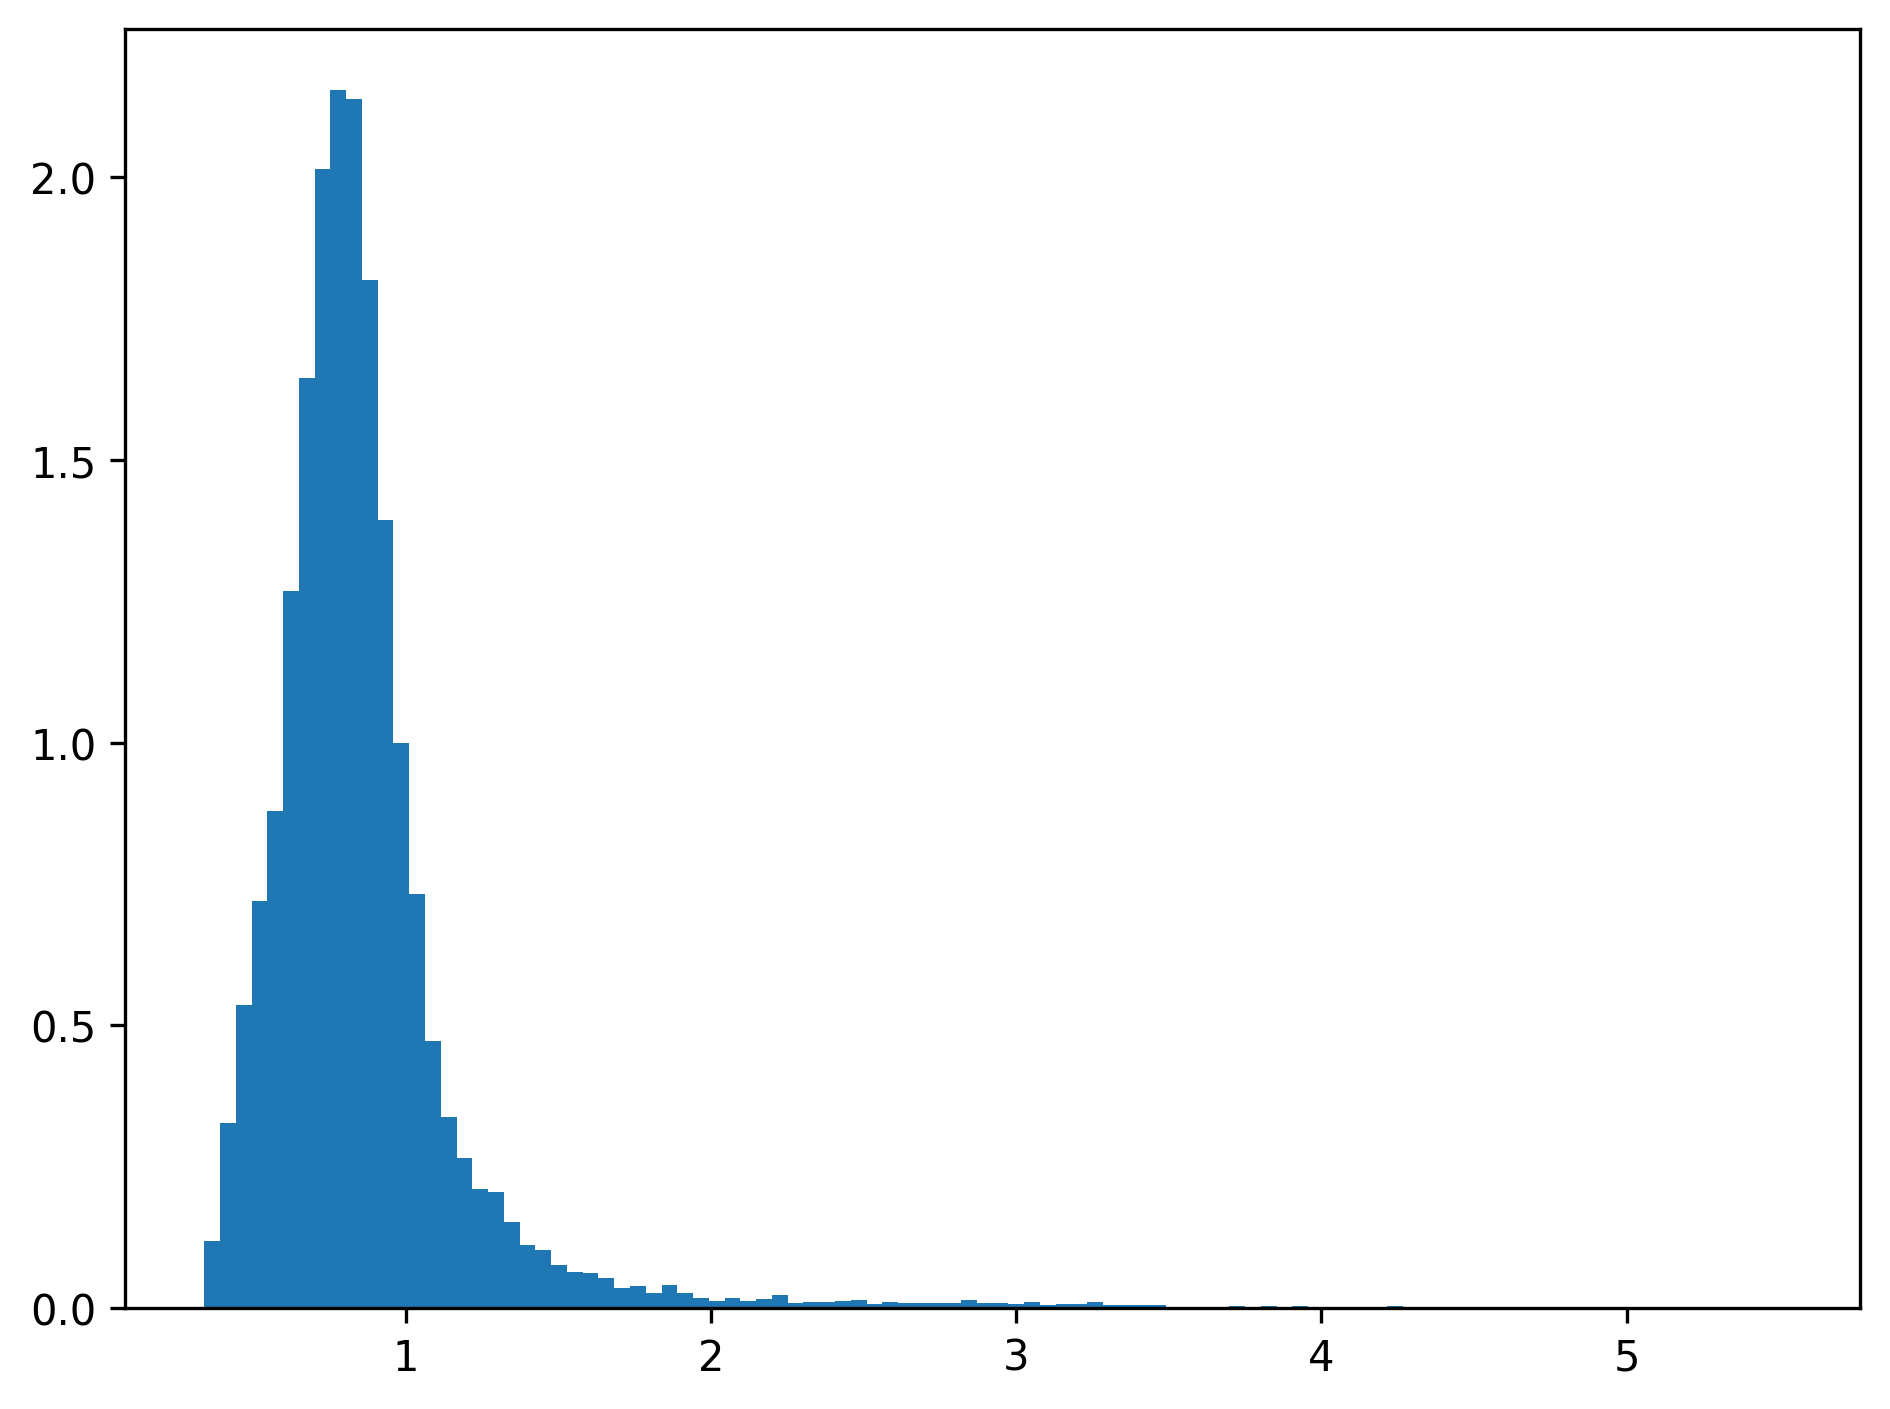

In [4]:
# Helper function to plot histogram of a column in a polars DataFrame
def pl_hist(df, column, n_bins=100,):
    data = df.select(pl.col(column))
    
    fig, ax = plt.subplots(1, 1, tight_layout=True)
    ax.hist(data, bins=n_bins, density=True)
    
    plt.show()
    plt.close()
    
# Plot histogram of mean expression values per cluster
pl_hist(exprData, "mean.cluster")

In [5]:
# Initialize the legacy fuzzifier for fuzzy logic transformation
lfz = LegacyFuzzifier()

centers [0.4, 0.8, 1.2, 1.6, 2, 2.4]
Creating Universe Range 0.0 -> 8.0 with step size 0.1
Mean Expr mean.cluster col 7
Expr Count expr.cluster col 12
SD sd.cluster col 8
Cluster cluster col 0
Combining over state:  False


/mnt/raidbio/extproj/projekte/FlowSets/examples/../flowset.py:661: RuntimeWarning: invalid value encountered in divide
  values = fuzz.trimf(self.universe, abc)/unscaledValues


to_homogeneous: cluster.2
to_homogeneous: cluster.3
to_homogeneous: cluster.1


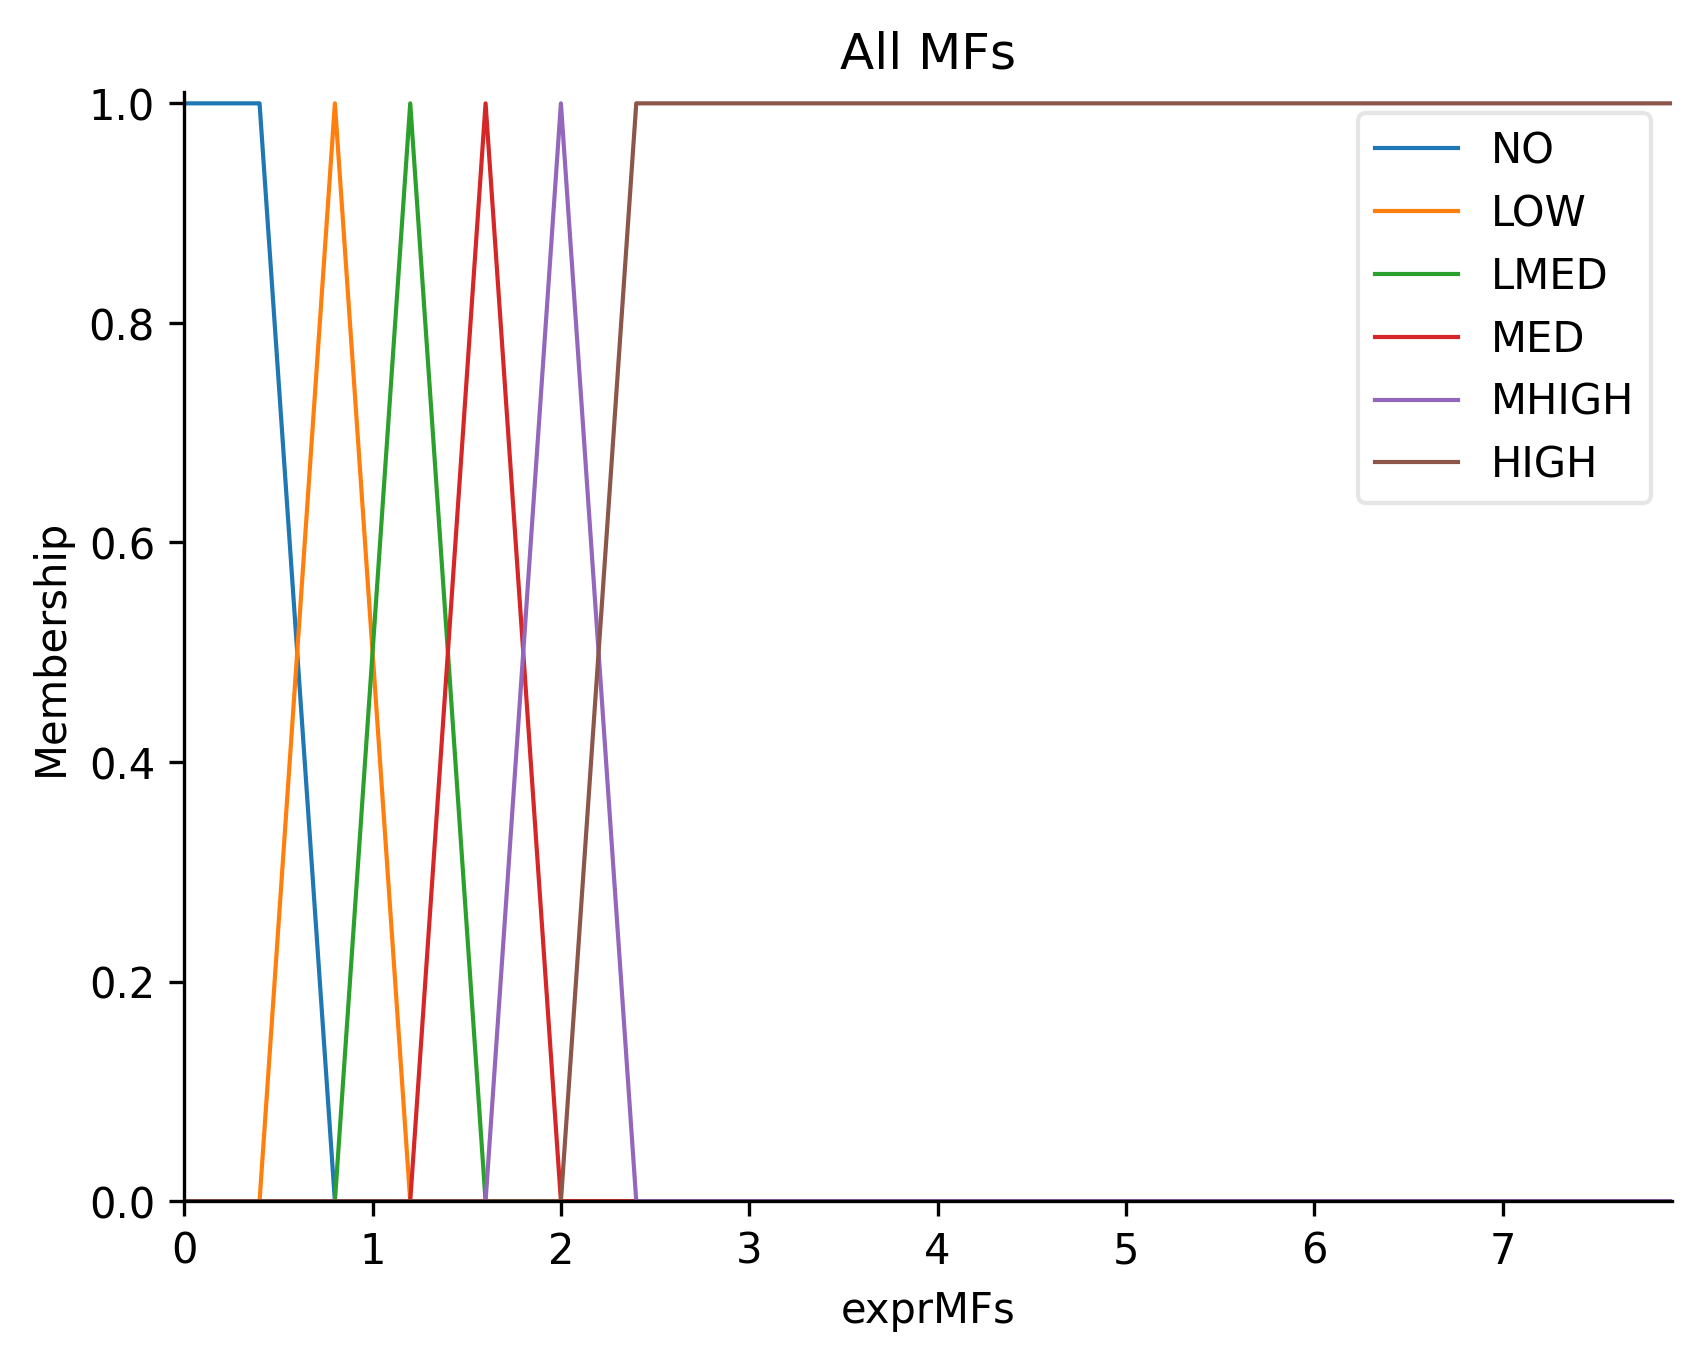

In [6]:
# Fuzzify the expression data using LegacyFuzzifier
# This transforms mean expression values into fuzzy membership scores for each state
explDFWide, mfFuzzy = LegacyFuzzifier.fuzzify(
    exprData, stepsize=0.1, 
    seriesOrder=["cluster.1","cluster.2","cluster.3"],
    mfLevels = ["NO","LOW","LMED","MED", "MHIGH", "HIGH"],
    centers=[0.4, 0.8, 1.2, 1.6, 2, 2.4]
)

In [7]:
# Define lists of interferon-stimulated genes (ISGs) for downstream analysis
isgListLong = sorted(set(["MX1","MX2","MT2A","RSAD2","SIGLEC1","IFIT1","IFI44","IFI27","IFITM10","IFIT3","IFI6","IFIT1P1","IFIT2","IFITM9P","IFI30","IFITM3","IFI44L","IFIT1B","IFITM5","IFITM3P2","IFITM3P9","IFI27L2","IFIT5","IFITM1","IFIH1","IFI16","IFI35","IFI27L1","IRF6","IRF7","IRF9","IRF5","IRF4","IRF2BP2","IRF2BPL","IRF3","IRF1-AS1","ISG15","ISG20L2","ISG20","XAF1","LY6E","IFITM2","IFITM3P6","IFITM3P3","IFIT6P","IRF2BP1","IRF5P1","IRF2","IRF1","IRF8","IFITM3P7","IFITM4P","IFITM3P1","IFITM3P8"]))
isgListShort = sorted(set(["MT2A", "ISG15", "LY6E", "IFIT1", "IFIT2", "IFIT3", "IFITM1", "IFITM3", "IFI44L", "IFI6", "MX1", "IFI27",  "IFI44L", "RSAD2", "SIGLEC1", "IFIT1"]))

In [8]:
# Create a FlowAnalysis object for the fuzzified data
# Map cluster timepoints to display names
fa = FlowAnalysis(
    explDFWide, "gene", 
    (  ("1", "TP 1"),("2", "TP 2"),("3", "TP 3")), 
    mfFuzzy, sep=".cluster."
)

In [9]:
# ...existing code...

In [10]:
# Create a color map for plotting flows by state
import seaborn as sns

scm = fa._create_series_color_map(None, "scaling")
icefires = sns.color_palette("icefire", len(scm)+2)

sc = {x: scm[x](1.0) for xi, x in enumerate(scm)}
# Alternative: assign colors from icefire palette
# sc = {x: icefires[xi+1] for xi, x in enumerate(scm)}
sc

{'TP 1': (np.float64(0.267004),
  np.float64(0.004874),
  np.float64(0.329415),
  np.float64(1.0)),
 'TP 2': (np.float64(0.190631),
  np.float64(0.407061),
  np.float64(0.556089),
  np.float64(1.0)),
 'TP 3': (np.float64(0.20803),
  np.float64(0.718701),
  np.float64(0.472873),
  np.float64(1.0))}

In [11]:
# ...existing code...

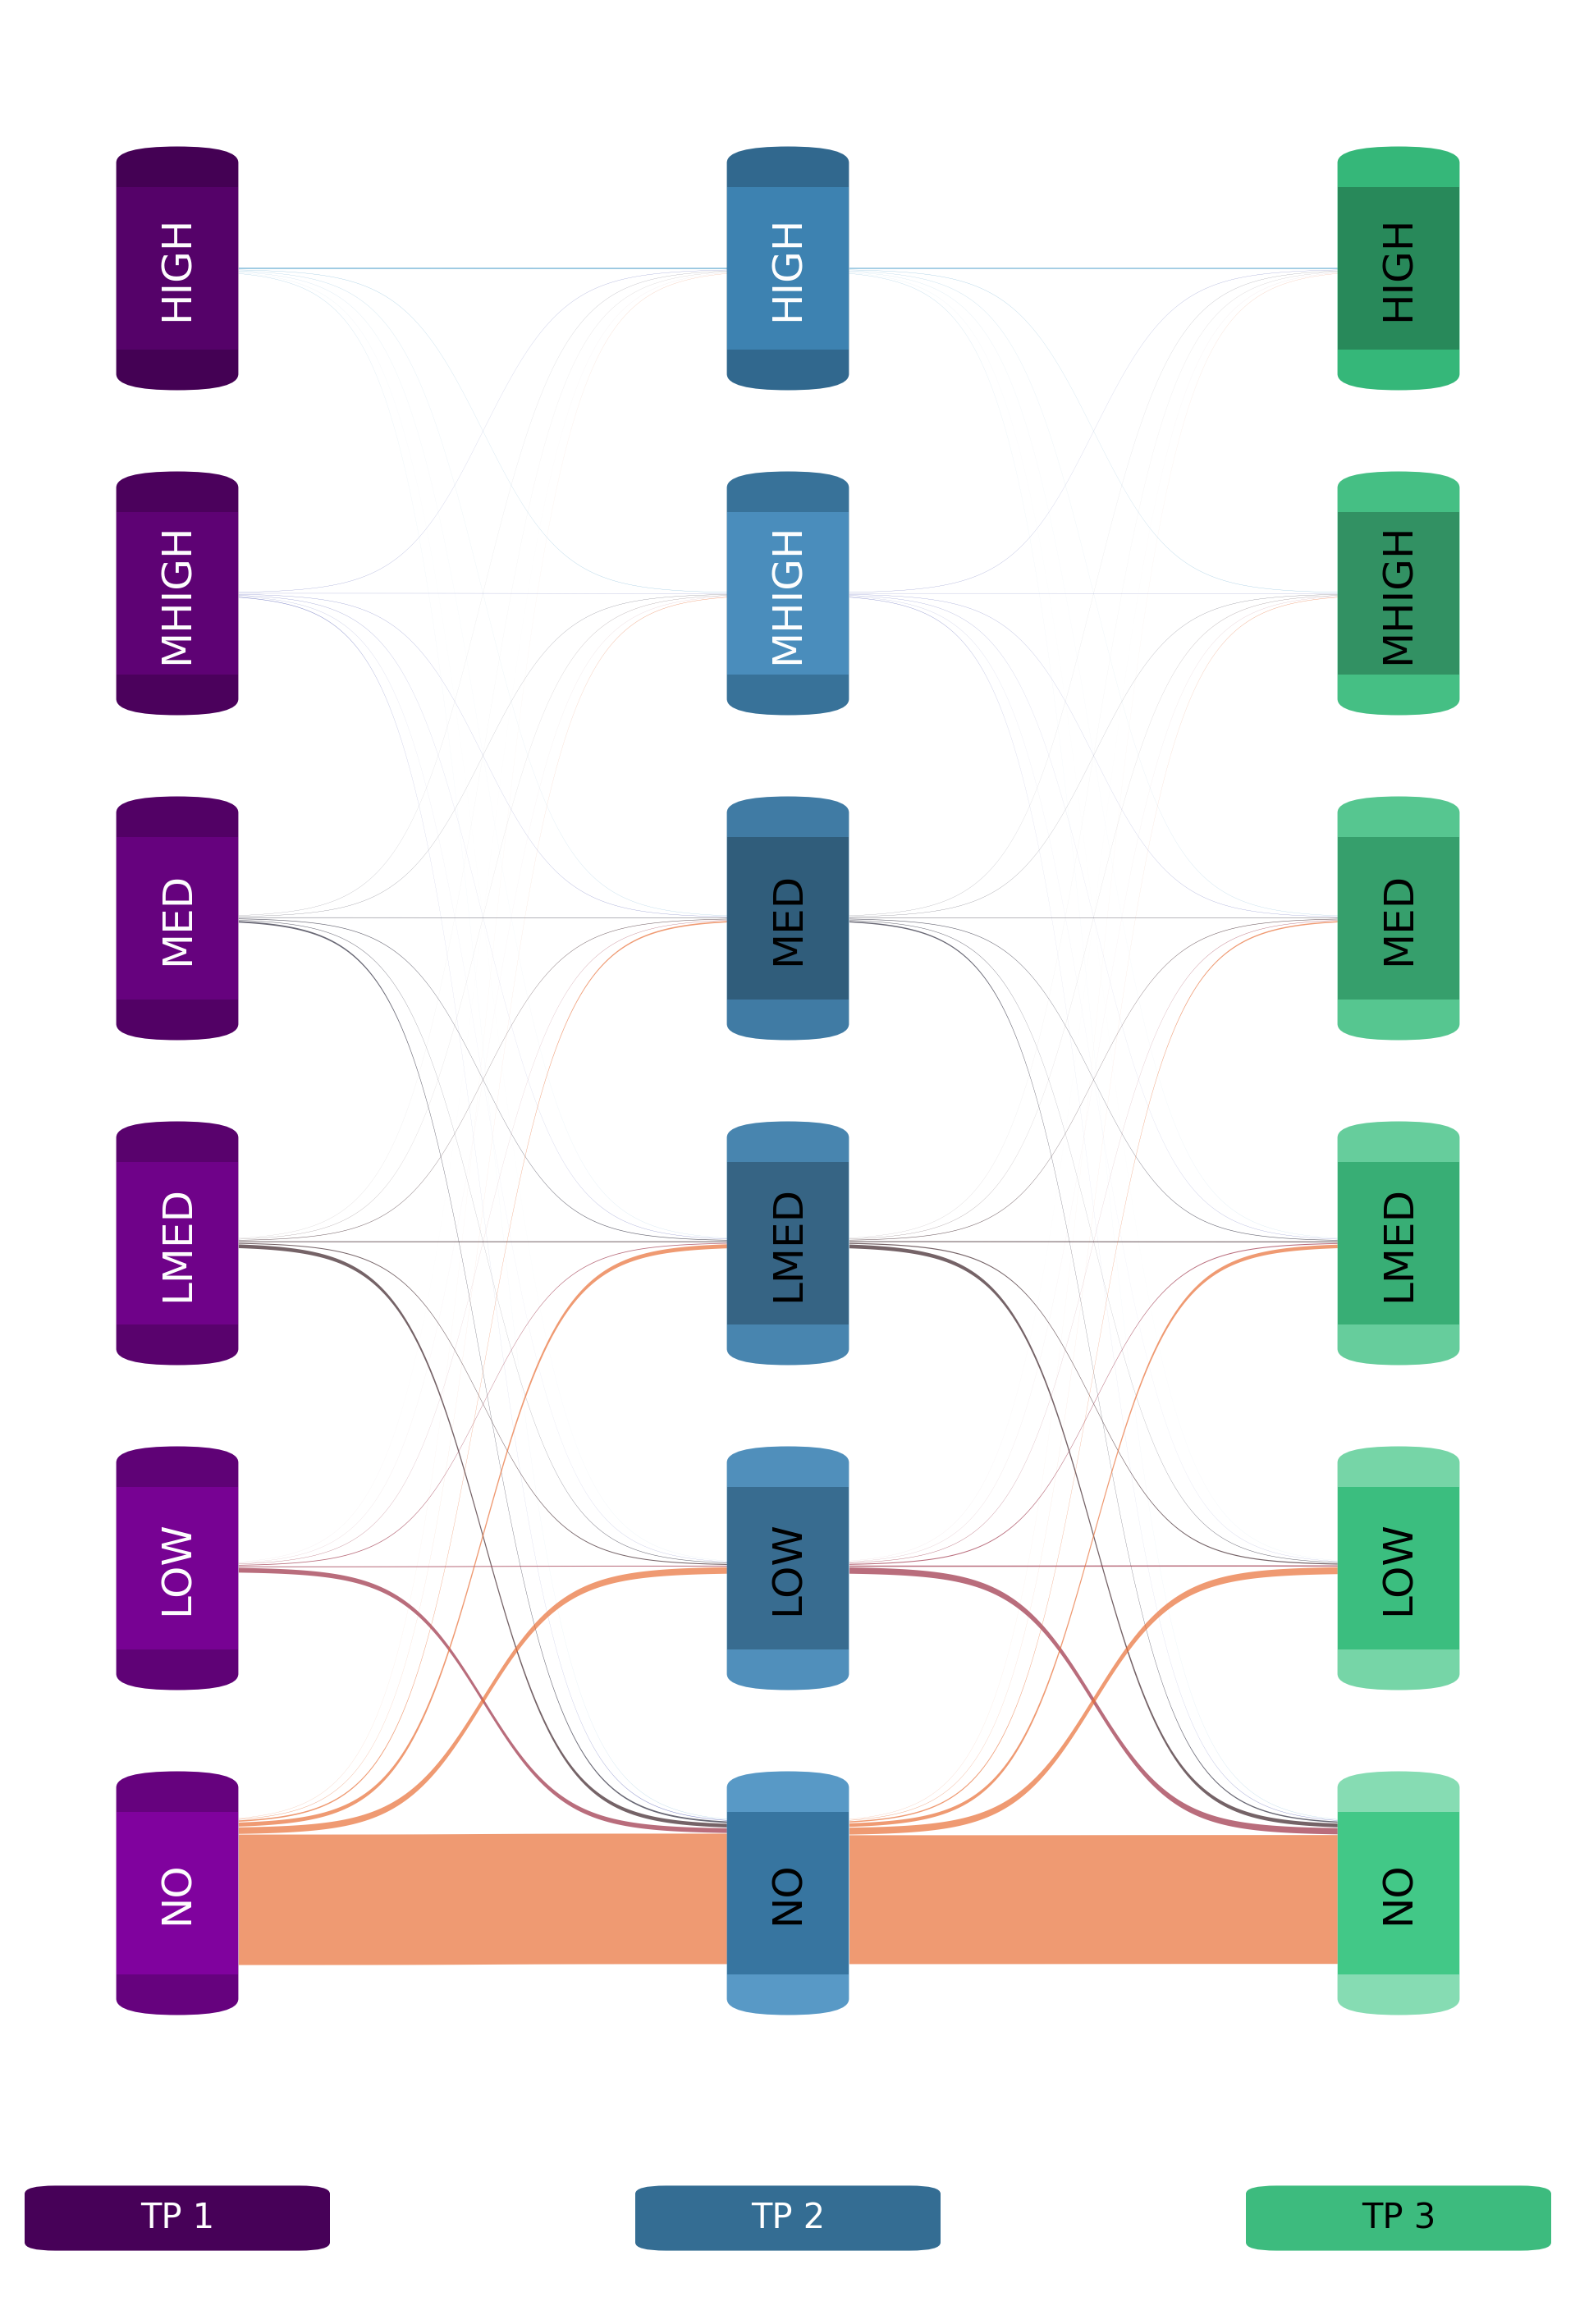

In [12]:
# Plot all flows with custom colors
fa.plot_flows(verbose=False, seriesColors=sc, figsize=(8,12))

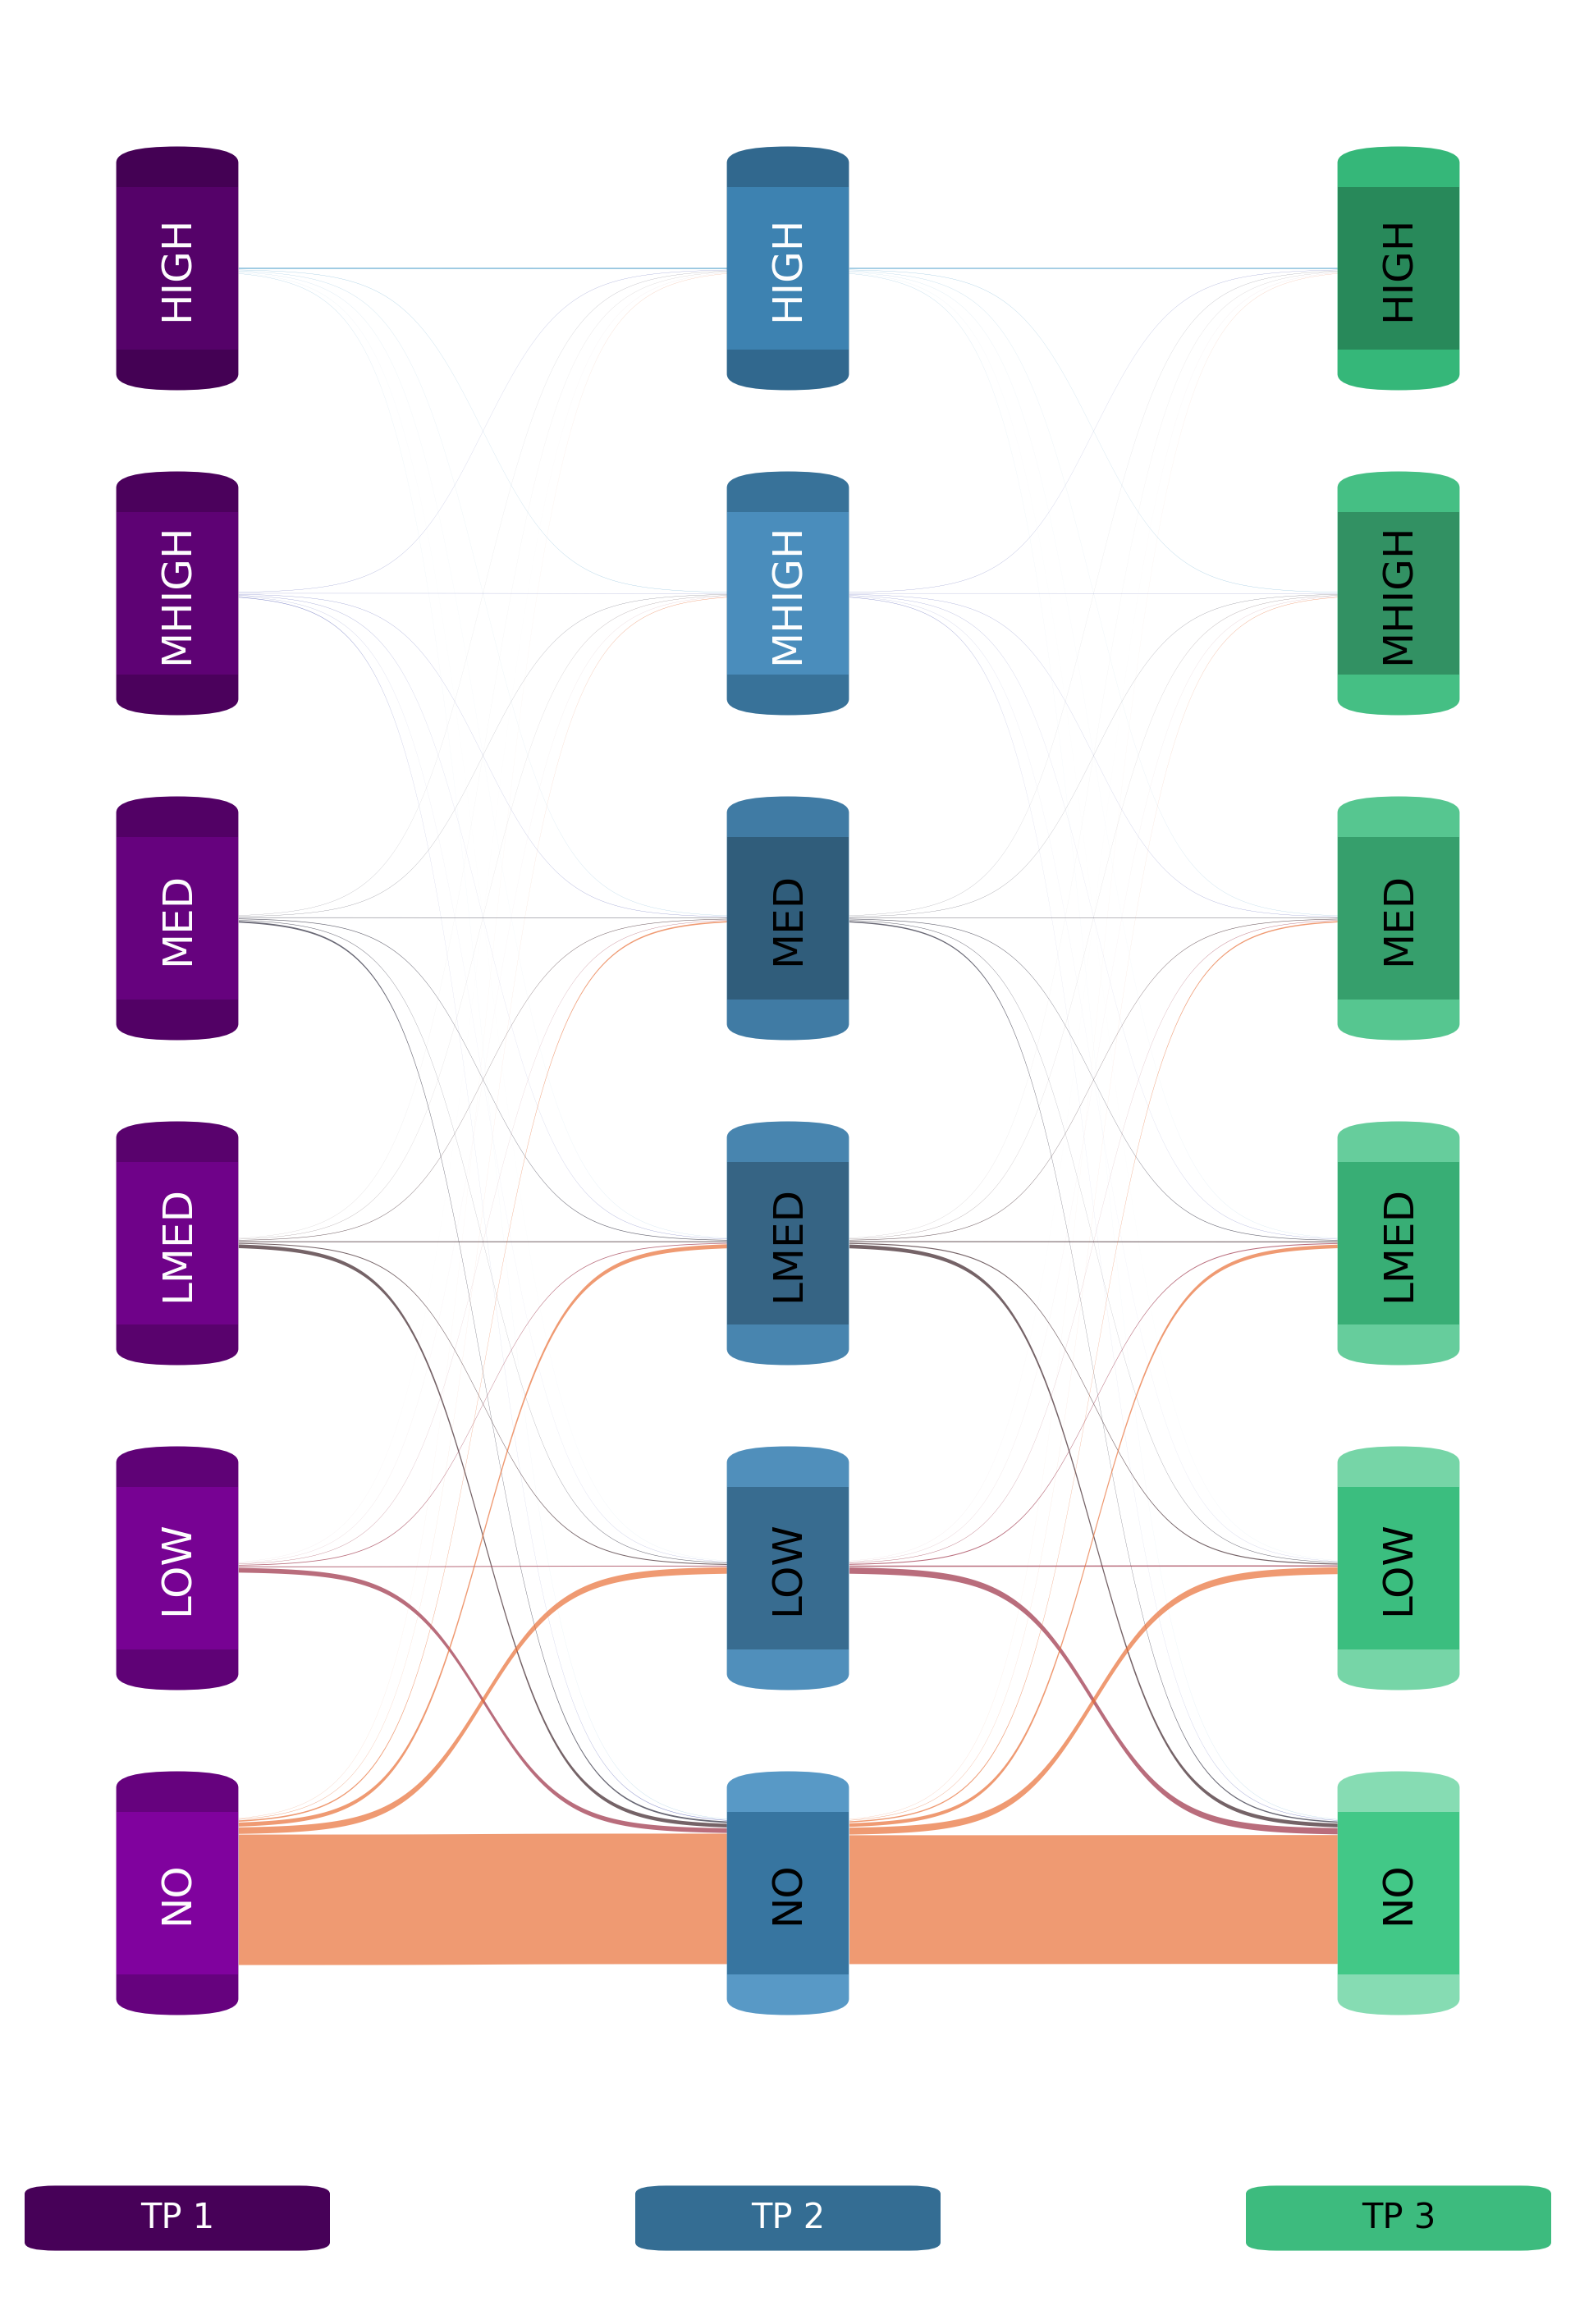

In [13]:
# Plot all flows and save to file
fa.plot_flows(outfile="plots/asympt_flows", seriesColors=sc, figsize=(8,12))

Creating FlowIDs
72 [('1', 'LMED'), ('2', 'NO'), ('3', 'NO')]
78 [('1', 'LMED'), ('2', 'LOW'), ('3', 'NO')]
79 [('1', 'LMED'), ('2', 'LOW'), ('3', 'LOW')]
108 [('1', 'MED'), ('2', 'NO'), ('3', 'NO')]
114 [('1', 'MED'), ('2', 'LOW'), ('3', 'NO')]
115 [('1', 'MED'), ('2', 'LOW'), ('3', 'LOW')]
120 [('1', 'MED'), ('2', 'LMED'), ('3', 'NO')]
121 [('1', 'MED'), ('2', 'LMED'), ('3', 'LOW')]
144 [('1', 'MHIGH'), ('2', 'NO'), ('3', 'NO')]
150 [('1', 'MHIGH'), ('2', 'LOW'), ('3', 'NO')]
151 [('1', 'MHIGH'), ('2', 'LOW'), ('3', 'LOW')]
156 [('1', 'MHIGH'), ('2', 'LMED'), ('3', 'NO')]
157 [('1', 'MHIGH'), ('2', 'LMED'), ('3', 'LOW')]
162 [('1', 'MHIGH'), ('2', 'MED'), ('3', 'NO')]
163 [('1', 'MHIGH'), ('2', 'MED'), ('3', 'LOW')]
180 [('1', 'HIGH'), ('2', 'NO'), ('3', 'NO')]
186 [('1', 'HIGH'), ('2', 'LOW'), ('3', 'NO')]
187 [('1', 'HIGH'), ('2', 'LOW'), ('3', 'LOW')]
192 [('1', 'HIGH'), ('2', 'LMED'), ('3', 'NO')]
193 [('1', 'HIGH'), ('2', 'LMED'), ('3', 'LOW')]
198 [('1', 'HIGH'), ('2', 'MED'), 

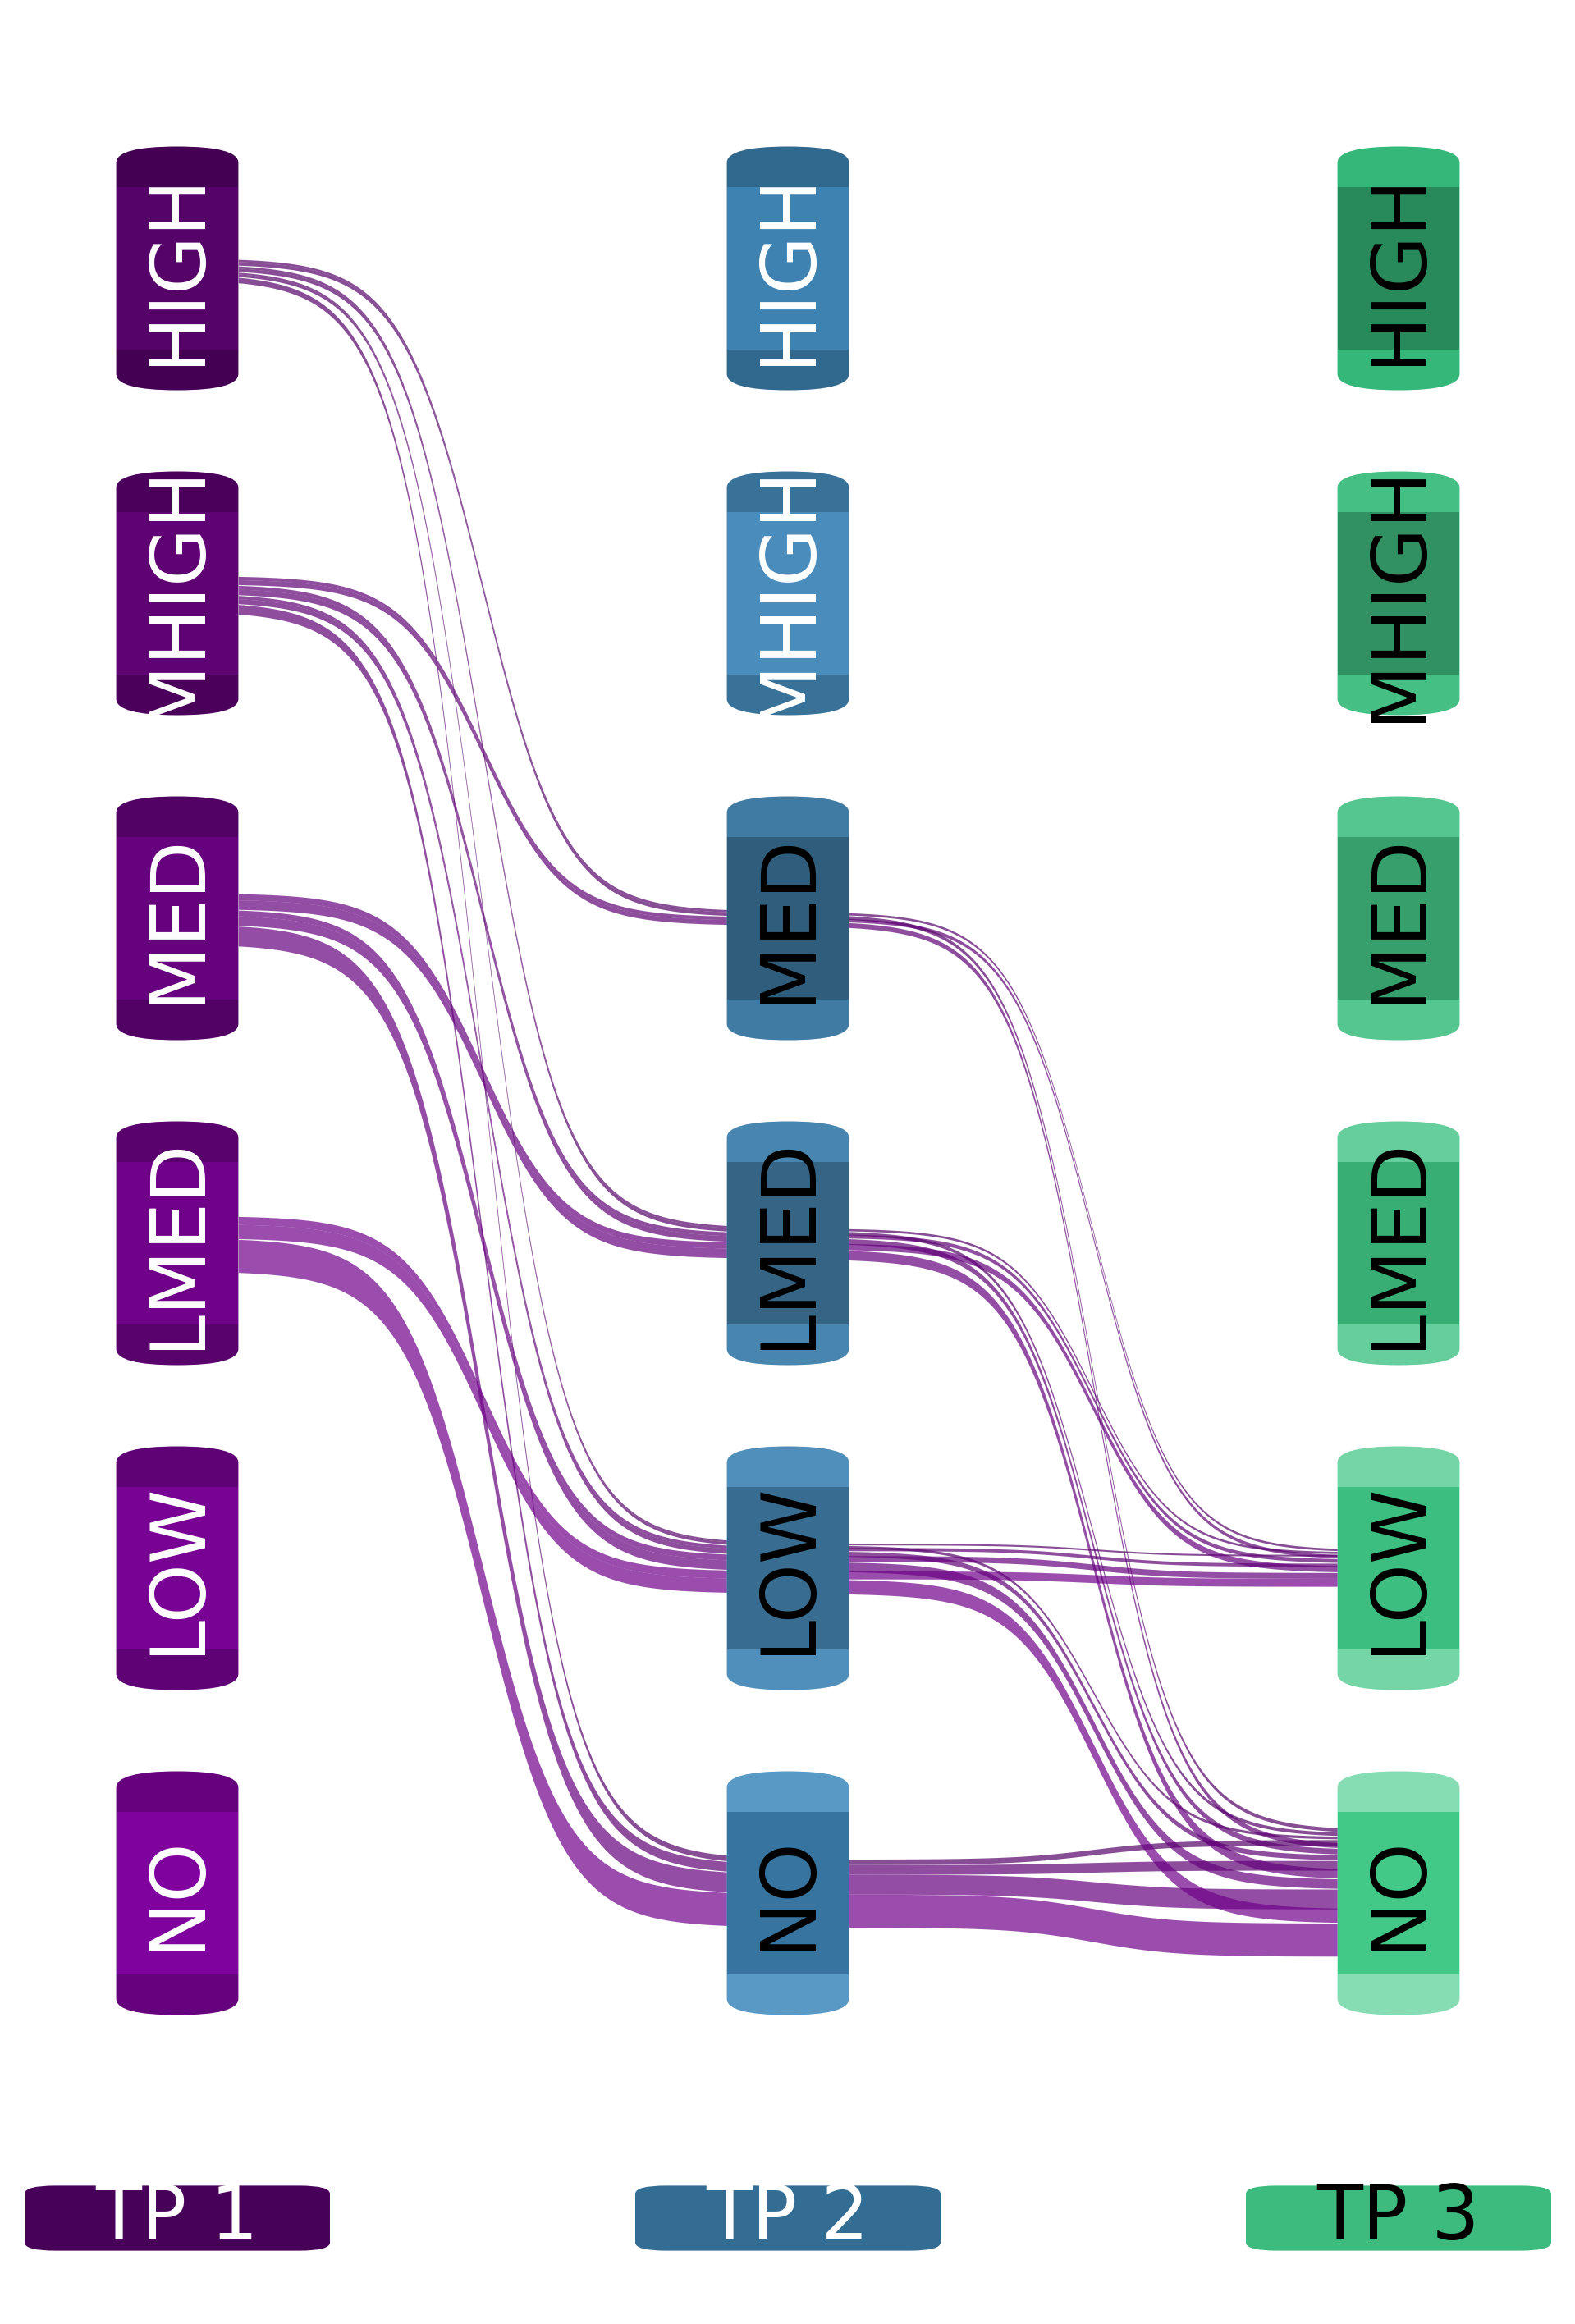

In [14]:
# Find relevant flow paths for genes with high expression in the first state
relFlows = fa.path_finder([">", ">="], minLevels=["LMED", None, None], maxLevels=["HIGH", "MED", "LOW"], verbose=True)

# Plot selected flow paths
fa.plot_paths(use_flows=relFlows, seriesColors=sc, figsize=(8,12), outfile="plots/asympt_selected_paths")

In [15]:
# Convert selected flow paths to edges for further analysis
relEdges = fa.paths2edges(relFlows)

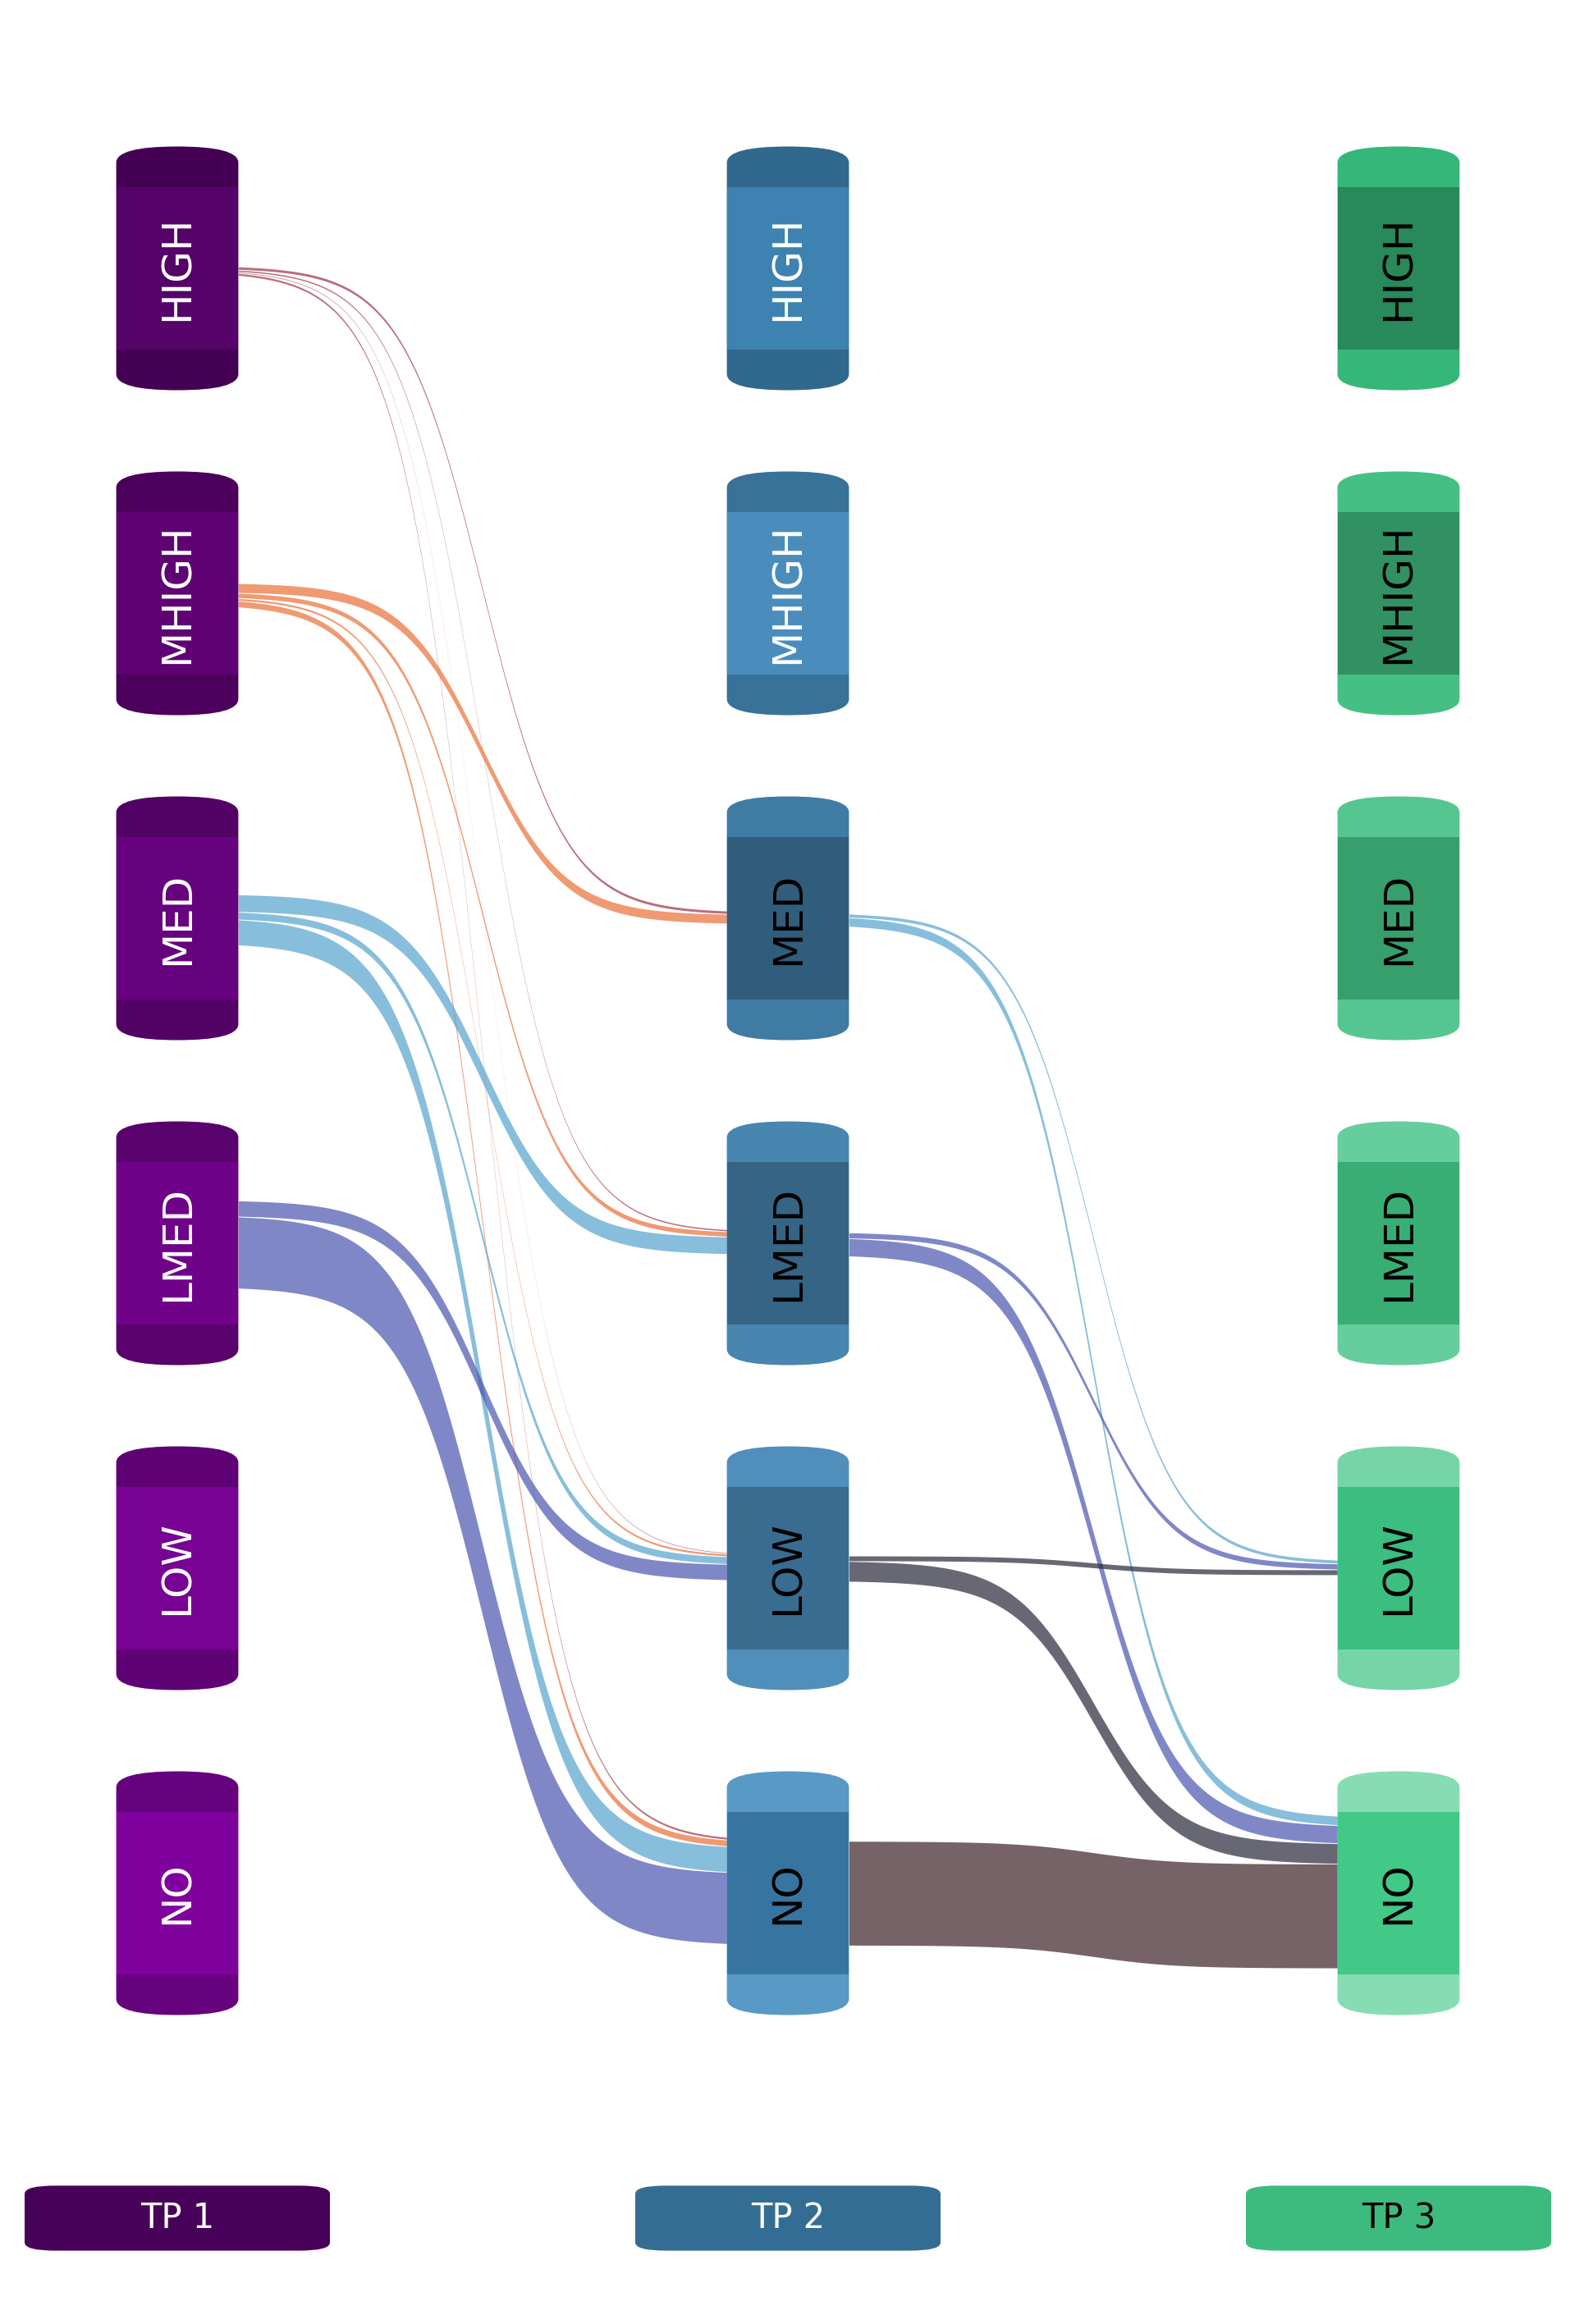

In [16]:
# Plot flows for selected edges
fa.plot_flows(relEdges, seriesColors=sc, figsize=(8,12), outfile="plots/asympt_selected_edges")

In [17]:
# ...existing code...

In [18]:
# Pathway analysis for selected edges using ISG gene sets
pwScoresGrp = fa.analyse_pathways(additional_genesets=[("ISG_SHORT", isgListShort), ("ISG_LONG", isgListLong)], use_edges=relEdges)
pwScoresGrp

Loading pathways from ReactomePathways.gmt
Identified 2612 pathways
Calculating p-values for groups [1, 2, 3, 4, 10, 50, 100, np.int64(2605)]


pwid                                             pwname  \
14     R-HSA-112122      ALKBH2 mediated reversal of alkylation damage   
17    R-HSA-5467333  APC truncation mutants are not K63 polyubiquit...   
30    R-HSA-9717264                     ASP-3026-resistant ALK mutants   
46    R-HSA-2978092  Abnormal conversion of 2-oxoglutarate to 2-hyd...   
160    R-HSA-211957  Aromatic amines can be N-hydroxylated or N-dea...   
...             ...                                                ...   
2566    R-HSA-72172                                      mRNA Splicing   
2567    R-HSA-72163                      mRNA Splicing - Major Pathway   
2592    R-HSA-72312                                    rRNA processing   
2594  R-HSA-8868773         rRNA processing in the nucleus and cytosol   
2603    R-HSA-72306                                    tRNA processing   

         pwFlow  pwGenes  allPwFlow   allPwGenes  pw_gene_intersection  \
14     0.005948        1  552.97245  7670.000133                     1   
17     0.058884        1  552.97245  7670.000133                     1   
30     0.000000        1  552.97245  7670.000133                     0   
46     0.036569        1  552.97245  7670.000133                     1   
160    0.000000        1  552.97245  7670.000133                     0   
...         ...      ...        ...          ...                   ...   
2566  16.833492      215  552.97245  7670.000133                   209   
2567  16.519390      204  552.97245  7670.000133                   201   
2592   5.956876      237  552.97245  7670.000133                   210   
2594   5.674849      199  552.97245  7670.000133                   188   
2603   3.681287      146  552.97245  7670.000133                   119   

      pw_coverage  genes_coverage  mean_coverage  pw_coverage_zscore  \
14       0.005948        0.000011   6.397366e-08           -0.875334   
17       0.058884        0.000106   6.270360e-06            0.334636   
30       0.000000        0.000000   0.000000e+00           -1.011282   
46       0.036569        0.000066   2.418409e-06           -0.175415   
160      0.000000        0.000000   0.000000e+00           -1.011282   
...           ...             ...            ...                 ...   
2566     0.078295        0.030442   2.383452e-03            1.921543   
2567     0.080977        0.029874   2.419103e-03            2.069545   
2592     0.025134        0.010772   2.707605e-04           -1.011949   
2594     0.028517        0.010262   2.926524e-04           -0.825307   
2603     0.025214        0.006657   1.678584e-04           -1.007545   

      pw_coverage_pval  pw_coverage_adj_pval  
14            1.000000              1.000000  
17            0.368950              1.000000  
30            1.000000              1.000000  
46            1.000000              1.000000  
160           1.000000              1.000000  
...                ...                   ...  
2566          0.027332              0.861751  
2567          0.019247              0.861751  
2592          1.000000              1.000000  
2594          1.000000              1.000000  
2603          1.000000              1.000000  

[2614 rows x 13 columns]

pwid                                             pwname  \
2612      ISG_SHORT                                          ISG_SHORT   
418   R-HSA-3134963  DEx/H-box helicases activate type I IFN and in...   
1876  R-HSA-9707587        Regulation of HMOX1 expression and activity   
224   R-HSA-9026403  Biosynthesis of DPAn-3-derived 13-series resol...   
848   R-HSA-2644605                 FBXW7 Mutants and NOTCH1 in Cancer   
1257  R-HSA-2644607  Loss of Function of FBXW7 in Cancer and NOTCH1...   
899    R-HSA-163210          Formation of ATP by chemiosmotic coupling   
105    R-HSA-114294  Activation, translocation and oligomerization ...   
2040  R-HSA-3065676               SUMO is conjugated to E1 (UBA2:SAE1)   
1963   R-HSA-611105                     Respiratory electron transport   
1910   R-HSA-211733  Regulation of activated PAK-2p34 by proteasome...   
2613       ISG_LONG                                           ISG_LONG   
1964   R-HSA-163200  Respiratory electron transport, ATP synthesis ...   
397   R-HSA-1236978  Cross-presentation of soluble exogenous antige...   
2288  R-HSA-6791462  TALDO1 deficiency: failed conversion of  Fru(6...   
206     R-HSA-77305   Beta oxidation of palmitoyl-CoA to myristoyl-CoA   
1880   R-HSA-877312                       Regulation of IFNG signaling   
2289  R-HSA-6791055  TALDO1 deficiency: failed conversion of SH7P, ...   
653   R-HSA-5660862  Defective SLC7A7 causes lysinuric protein into...   
2020    R-HSA-77588  SLBP Dependent Processing of Replication-Depen...   

         pwFlow  pwGenes  allPwFlow   allPwGenes  pw_gene_intersection  \
2612   4.355990       14  552.97245  7670.000133                    14   
418    1.124470        7  552.97245  7670.000133                     7   
1876   0.730125        5  552.97245  7670.000133                     5   
224    0.174329        1  552.97245  7670.000133                     1   
848    0.631823        5  552.97245  7670.000133                     5   
1257   0.631823        5  552.97245  7670.000133                     5   
899    2.100814       18  552.97245  7670.000133                    18   
105    0.359034        2  552.97245  7670.000133                     2   
2040   0.621183        5  552.97245  7670.000133                     5   
1963  10.049649      103  552.97245  7670.000133                   103   
1910   5.691135       50  552.97245  7670.000133                    48   
2613   7.879286       55  552.97245  7670.000133                    40   
1964  12.355905      127  552.97245  7670.000133                   124   
397    5.666497       50  552.97245  7670.000133                    45   
2288   0.169360        1  552.97245  7670.000133                     1   
206    0.451472        3  552.97245  7670.000133                     3   
1880   1.508702       14  552.97245  7670.000133                    14   
2289   0.169360        1  552.97245  7670.000133                     1   
653    0.331367        2  552.97245  7670.000133                     2   
2020   1.165380       11  552.97245  7670.000133                    11   

      pw_coverage  genes_coverage  mean_coverage  pw_coverage_zscore  \
2612     0.311142        0.007877       0.002451           11.564105   
418      0.160639        0.002034       0.000327            4.262085   
1876     0.146025        0.001320       0.000193            3.752800   
224      0.174329        0.000315       0.000055            2.973365   
848      0.126365        0.001143       0.000144            3.067623   
1257     0.126365        0.001143       0.000144            3.067623   
899      0.116712        0.003799       0.000443            3.239578   
105      0.179517        0.000649       0.000117            3.127470   
2040     0.124237        0.001123       0.000140            2.993460   
1963     0.097569        0.018174       0.001773            2.985117   
1910     0.113823        0.010292       0.001171            3.115878   
2613     0.143260        0.014249       0

Index(['pwid', 'pwname', 'pwFlow', 'pwGenes', 'allPwFlow', 'allPwGenes',
       'pw_gene_intersection', 'pw_coverage', 'genes_coverage',
       'mean_coverage', 'pw_coverage_zscore', 'pw_coverage_pval',
       'pw_coverage_adj_pval'],
      dtype='object')
False
False
(10, 14)


/mnt/raidbio/extproj/projekte/FlowSets/examples/../flowset.py:3059: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


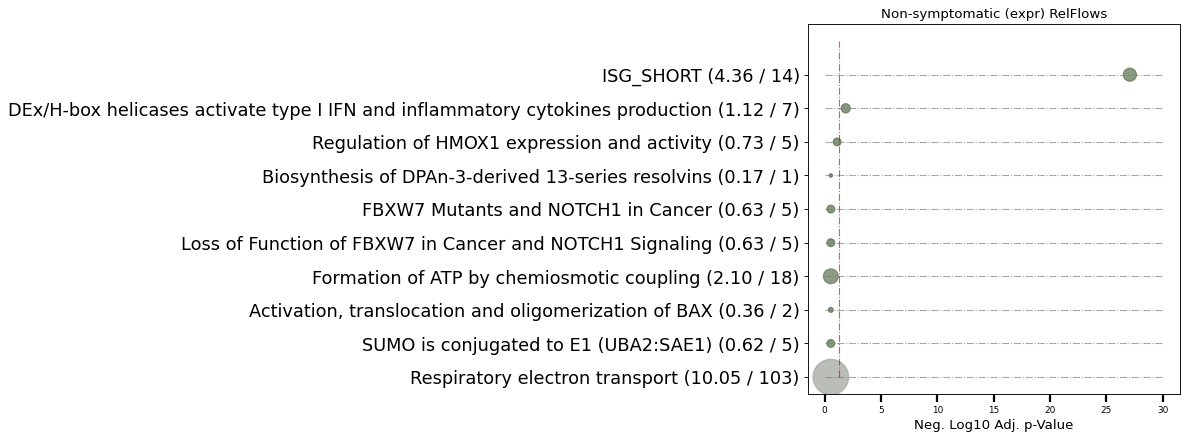

In [19]:
# Select and plot top pathways for non-symptomatic group
selPWsGrp = pwScoresGrp[(pwScoresGrp["pw_coverage_adj_pval"] < 1)].sort_values("pw_coverage_adj_pval", ascending=True).head(20)
display(selPWsGrp)
fa.plotORAresult(selPWsGrp, "Non-symptomatic (expr) RelFlows", numResults=10, figsize=(6,6), outfile="plots/asympt_ra")

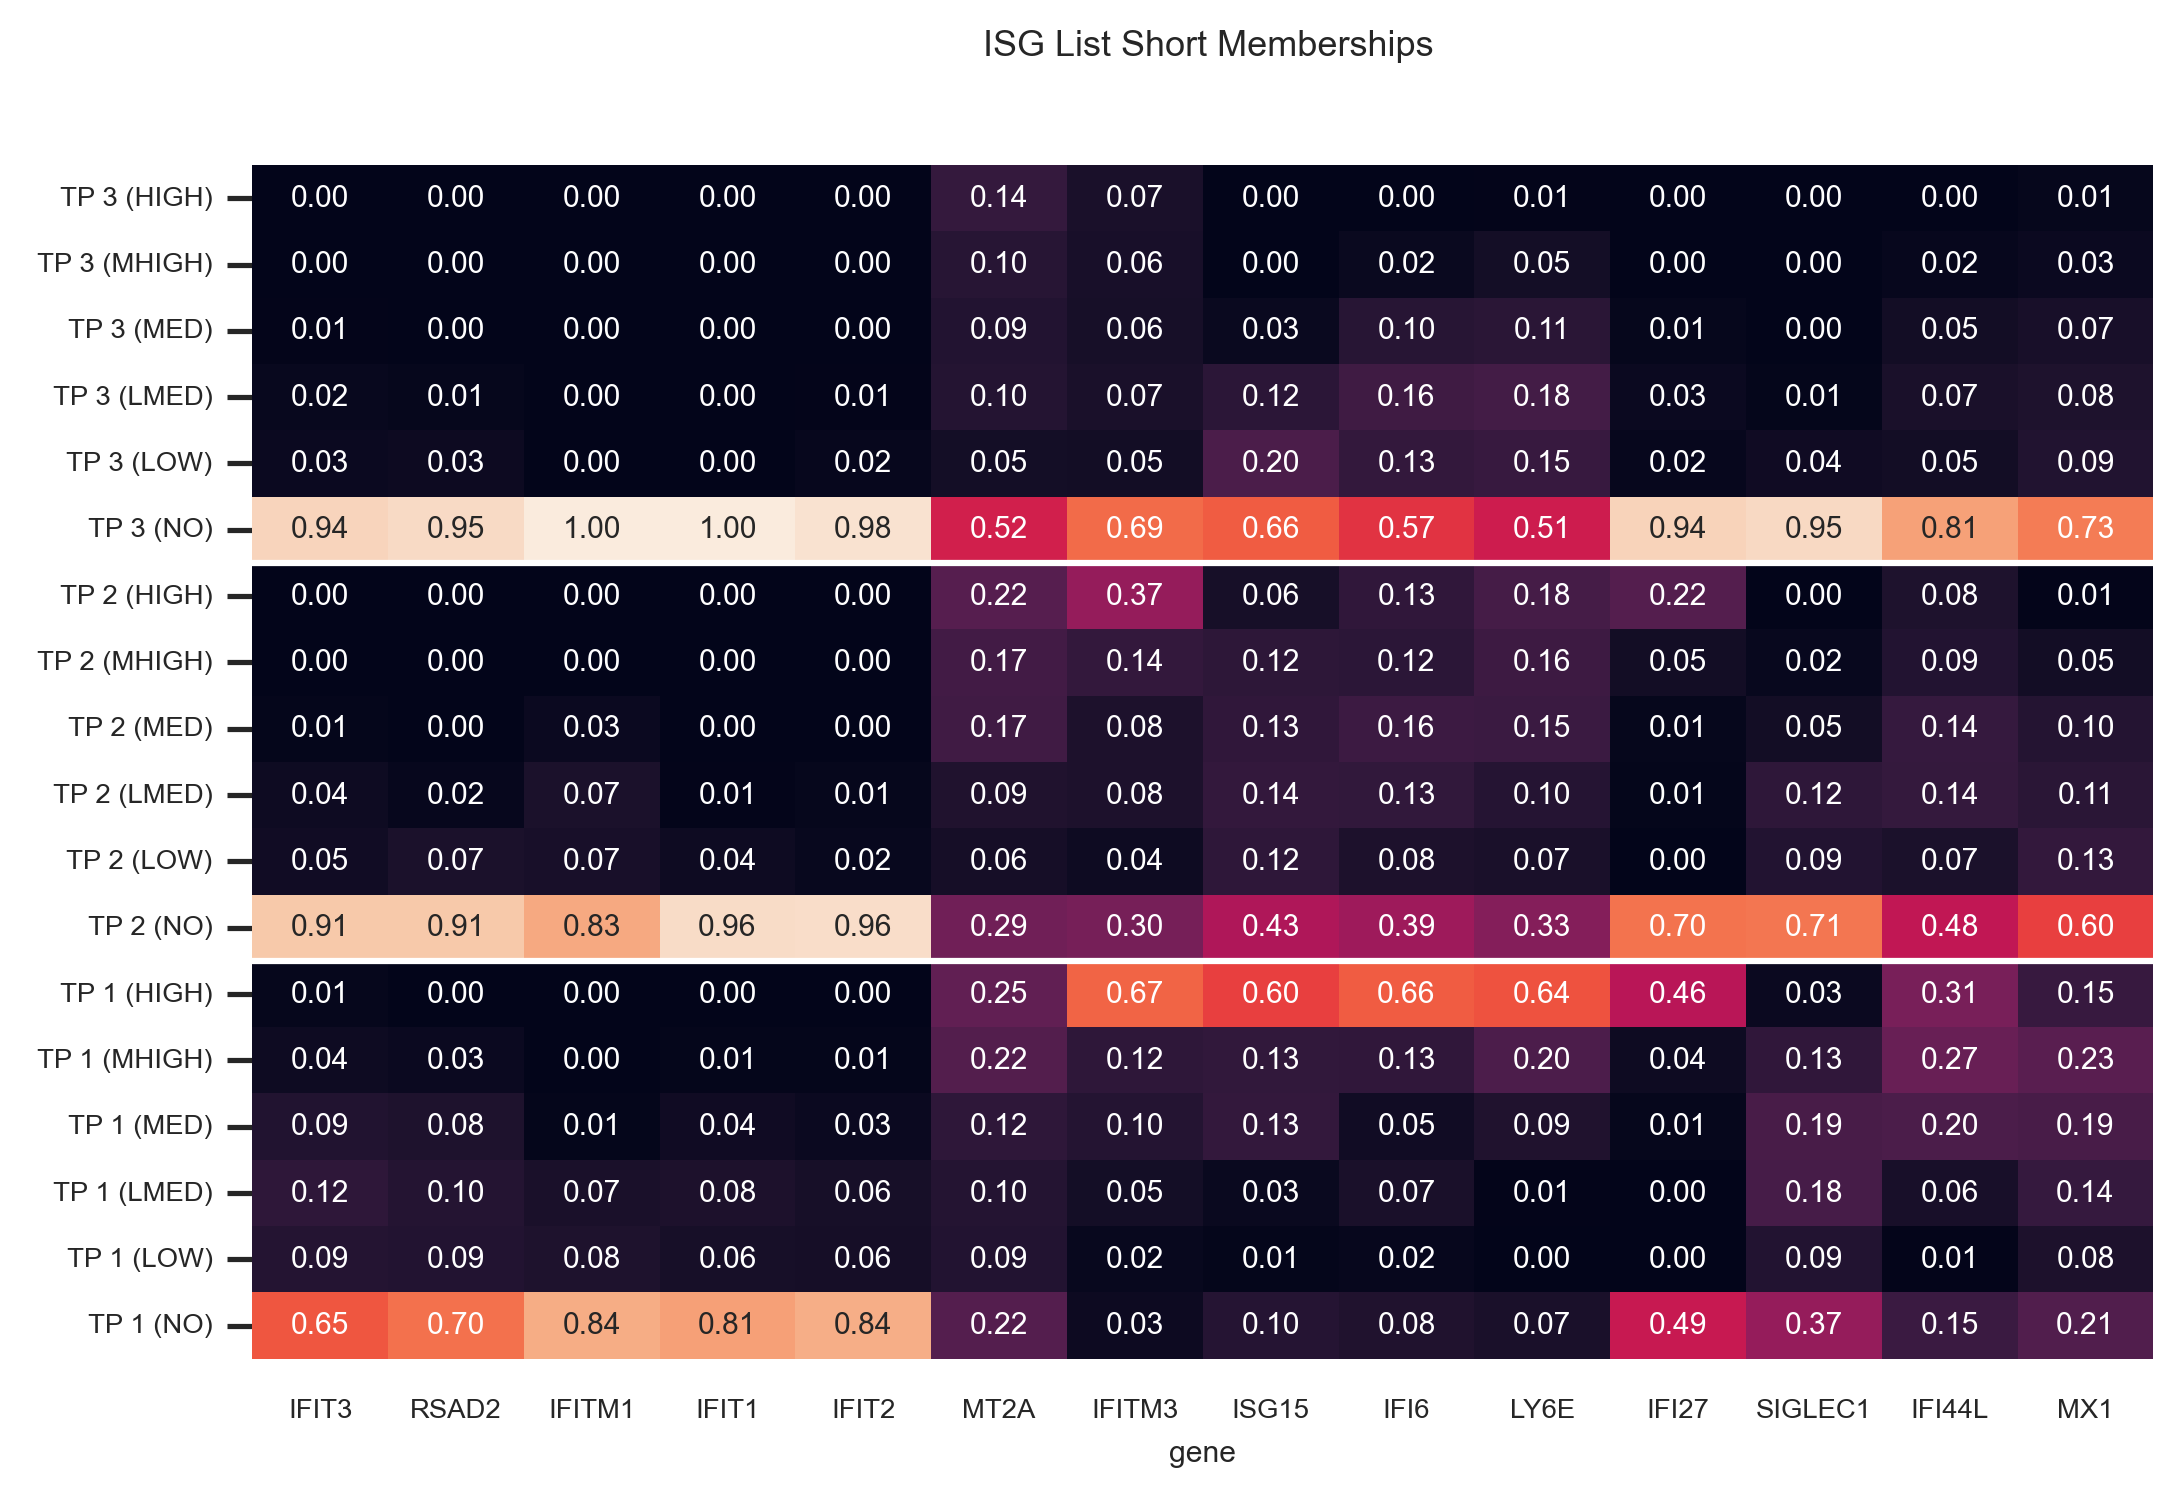

In [20]:
# Plot state memberships for the short ISG list
_ = fa.plot_state_memberships(genes=isgListShort, name="ISG List Short Memberships", cluster_genes=True, outfile="plots/asympt_memberships",prefix="", font_scale=0.6, figsize=(8,5))

Found 12 of 55 (query) in 25 (top) genes.


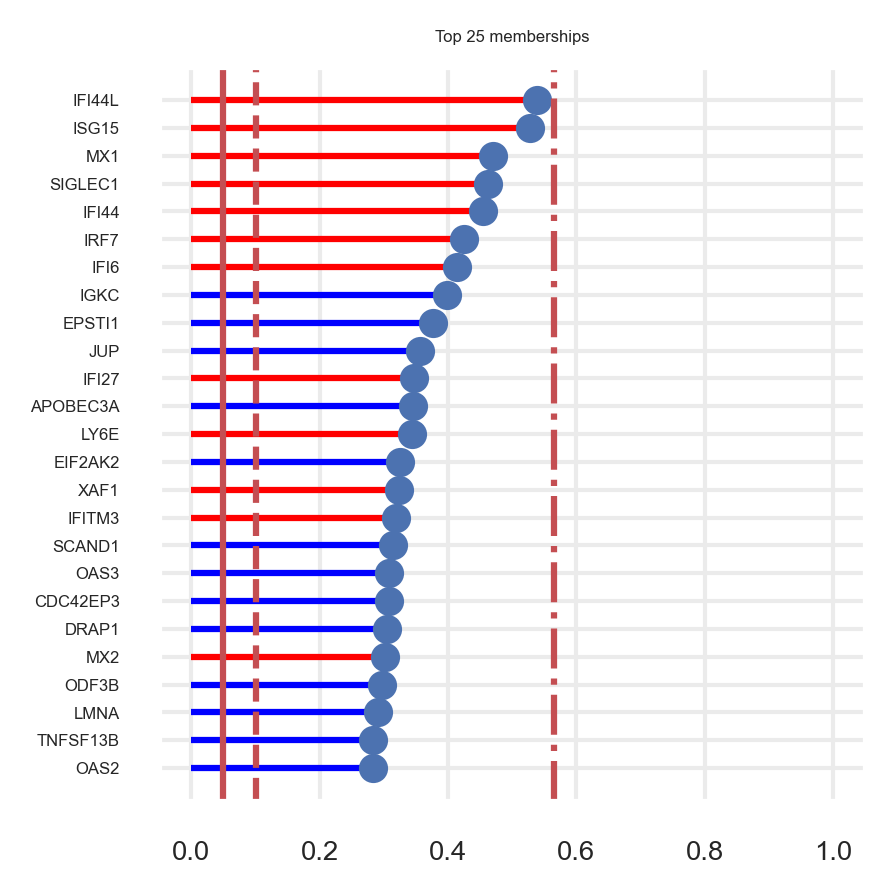

In [21]:
# Plot flow memberships for selected edges, highlighting ISG genes
_ = fa.plot_flow_memberships(use_edges=relEdges, outfile="plots/asympt_flow_memberships", n_genes=25, gene_exclude_patterns=["AC", "AF", "AL", "LINC"], color_genes=isgListLong,figsize=(3,3), plot_histogram=False)

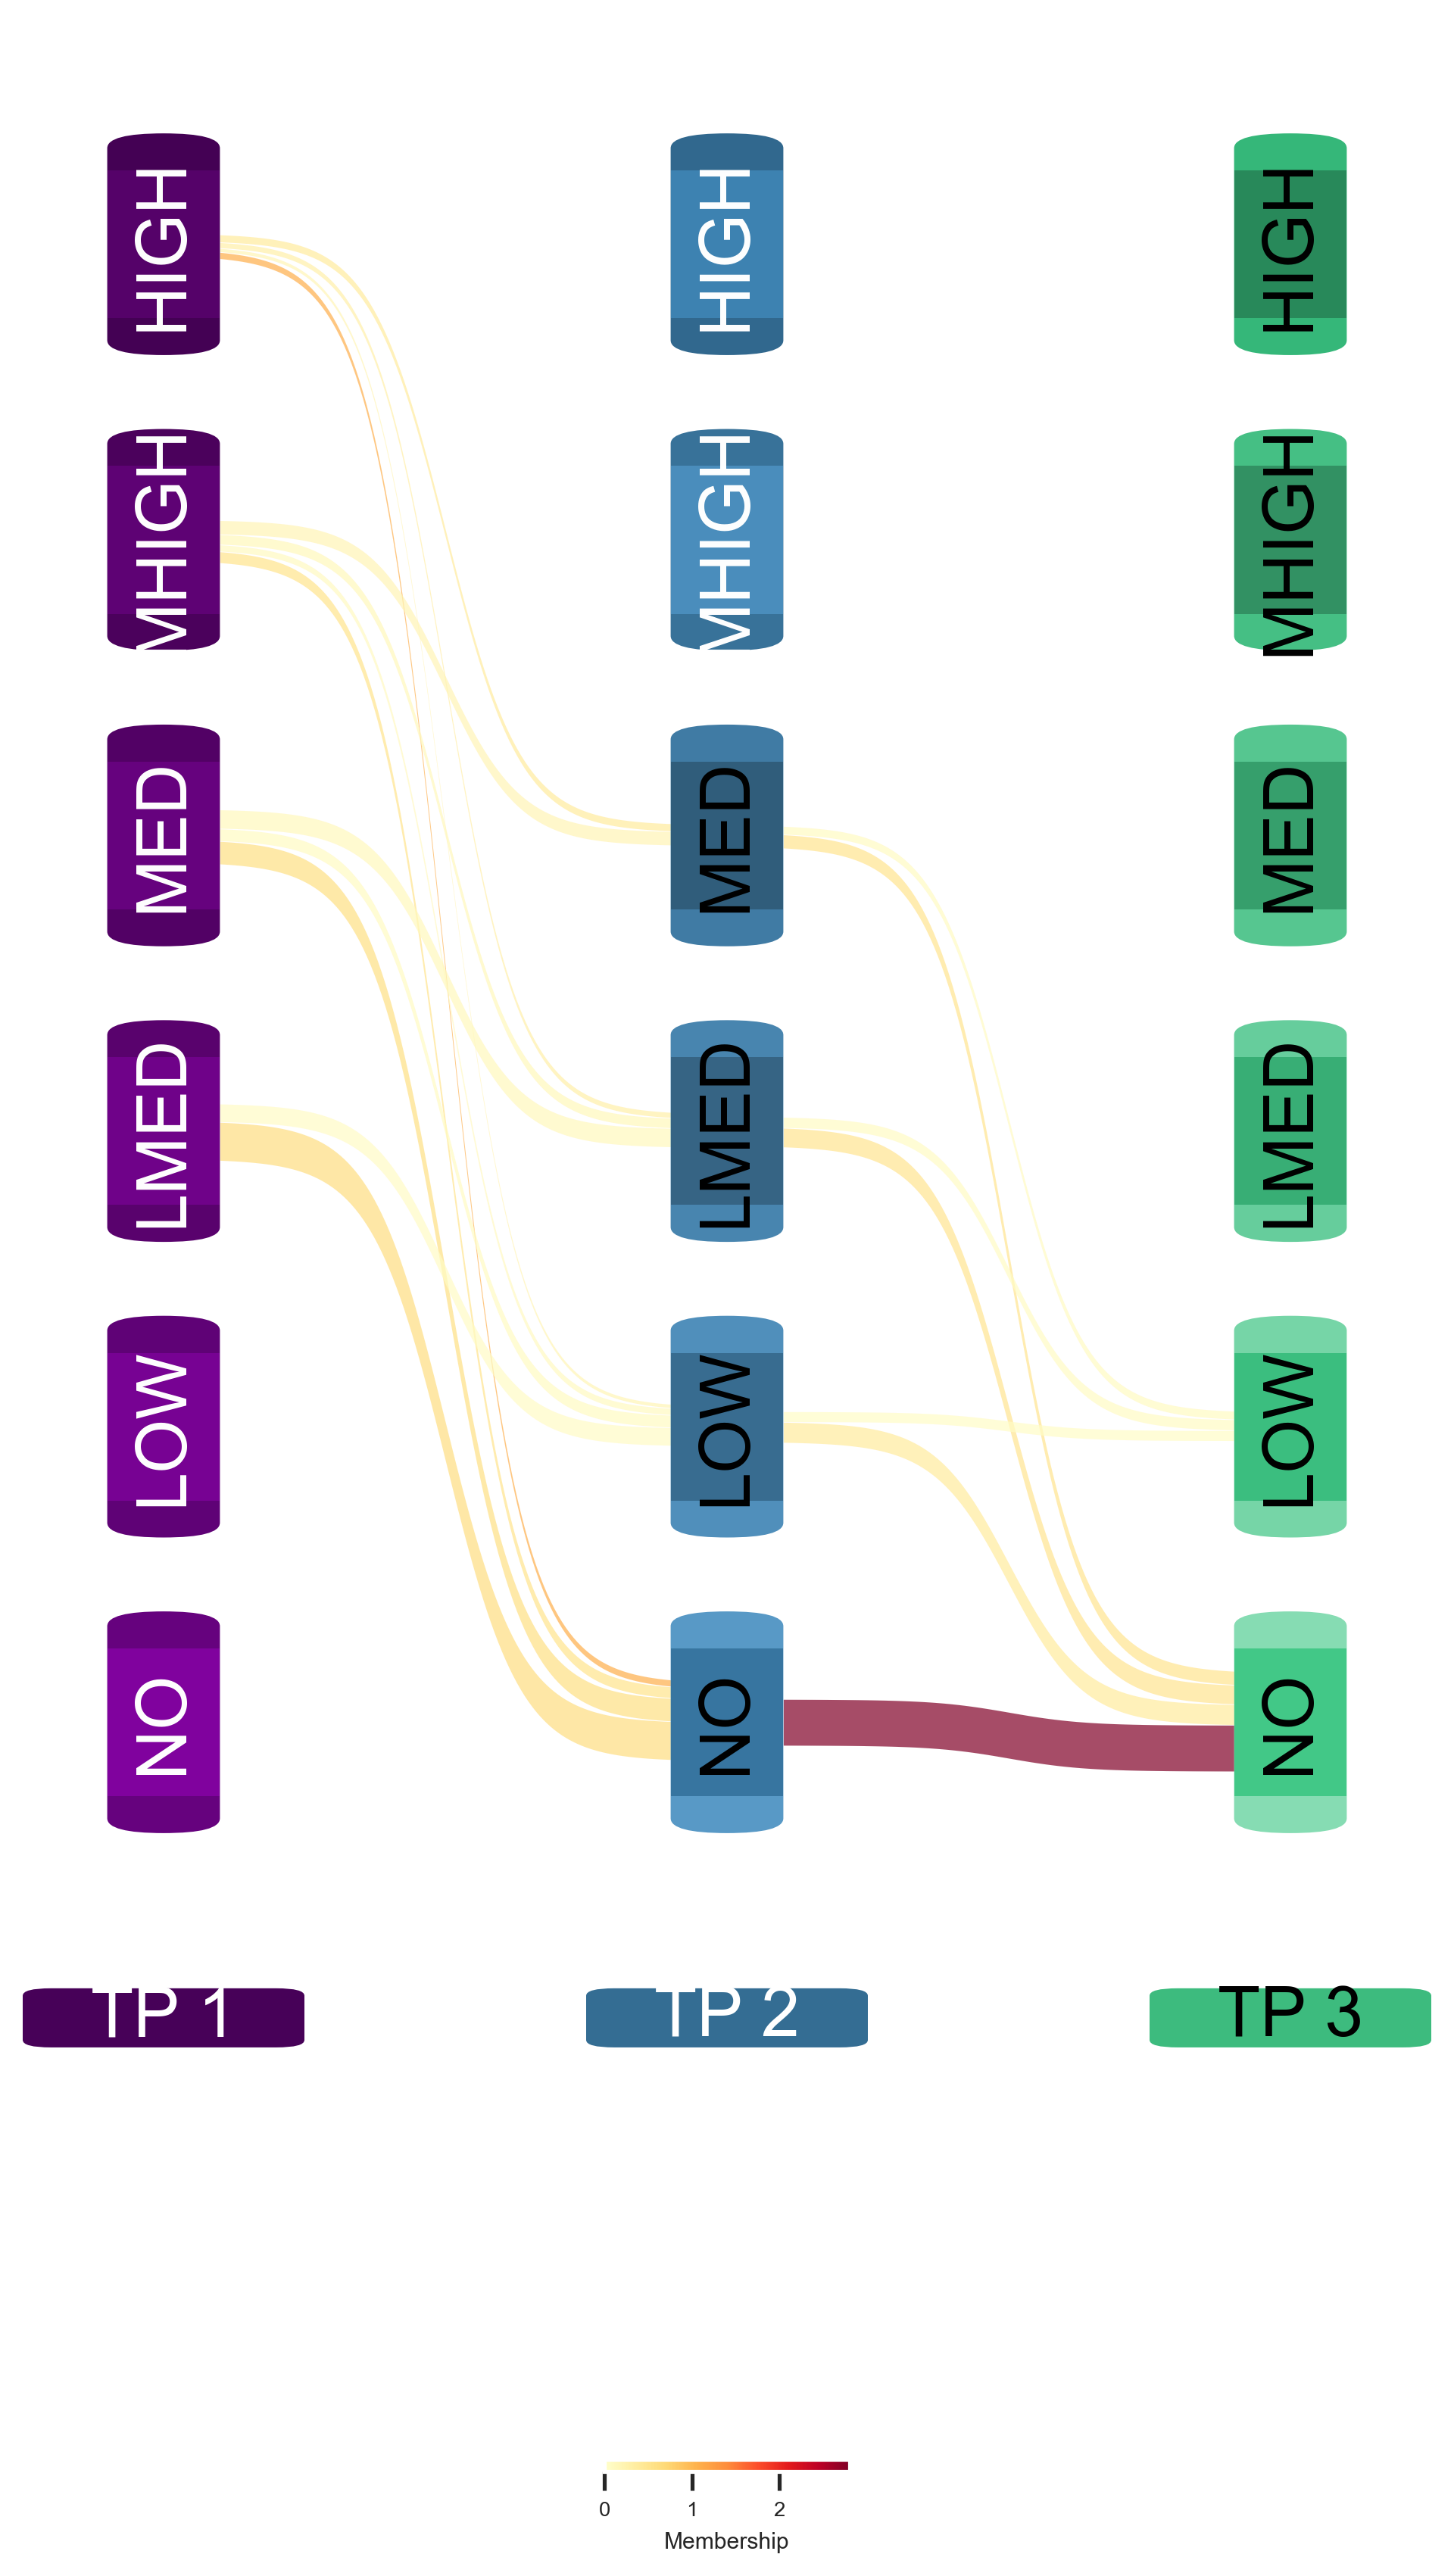

In [22]:
# Visualize ISG genes for selected edges
_ = fa.visualize_genes(genes=isgListShort, use_edges=relEdges, outfile="plots/asympt_isg_flow", figsize=(8,14), seriesColors=sc)

In [23]:
# Pathway analysis using GO biological process gene sets
pwScoresGrpGO = fa.analyse_pathways(genesets_file="go_human.bp.gmt", additional_genesets=[("ISG_SHORT", isgListShort), ("ISG_LONG", isgListLong)], use_edges=relEdges)
pwScoresGrpGO

Loading pathways from go_human.bp.gmt
Identified 12535 pathways
Calculating p-values for groups [1, 2, 3, 4, 10, 50, 100, np.int64(1226)]


pwid                                             pwname    pwFlow  \
7     GO:0010789  meiotic sister chromatid cohesion involved in ...  0.000000   
20    GO:1900101  regulation of endoplasmic reticulum unfolded p...  0.015696   
25    GO:0043610             regulation of carbohydrate utilization  0.000000   
28    GO:0072522    purine-containing compound biosynthetic process  0.000000   
53    GO:0043416  regulation of skeletal muscle tissue regeneration  0.000000   
...          ...                                                ...       ...   
1774  GO:0010976  positive regulation of neuron projection devel...  3.472634   
1860  GO:0001822                                 kidney development  2.484113   
1861  GO:0007568                                              aging  5.063857   
1881  GO:0018108                  peptidyl-tyrosine phosphorylation  4.821593   
2493  GO:0006457                                    protein folding  7.416216   

      pwGenes  allPwFlow  allPwGenes  pw_gene_intersection  pw_coverage  \
7           1  552.97245  11415.0002                     1     0.000000   
20          1  552.97245  11415.0002                     1     0.015696   
25          1  552.97245  11415.0002                     0     0.000000   
28          1  552.97245  11415.0002                     0     0.000000   
53          1  552.97245  11415.0002                     0     0.000000   
...       ...        ...         ...                   ...          ...   
1774      111  552.97245  11415.0002                    73     0.031285   
1860      115  552.97245  11415.0002                    64     0.021601   
1861      146  552.97245  11415.0002                   102     0.034684   
1881      139  552.97245  11415.0002                    99     0.034688   
2493      156  552.97245  11415.0002                   123     0.047540   

      genes_coverage  mean_coverage  pw_coverage_zscore  pw_coverage_pval  \
7           0.000000   0.000000e+00           -1.006108          1.000000   
20          0.000028   4.455045e-07           -0.734194          1.000000   
25          0.000000   0.000000e+00           -1.006108          1.000000   
28          0.000000   0.000000e+00           -1.006108          1.000000   
53          0.000000   0.000000e+00           -1.006108          1.000000   
...              ...            ...                 ...               ...   
1774        0.006280   1.964679e-04           -0.235767          1.000000   
1860        0.004492   9.703789e-05           -0.925635          1.000000   
1861        0.009158   3.176190e-04            0.006367          0.497460   
1881        0.008719   3.024565e-04            0.006635          0.497353   
2493        0.013412   6.375829e-04            0.922192          0.178214   

      pw_coverage_adj_pval  
7                      1.0  
20                     1.0  
25                     1.0  
28                     1.0  
53                     1.0  
...                    ...  
1774                   1.0  
1860                   1.0  
1861                   1.0  
1881                   1.0  
2493                   1.0  

[12537 rows x 13 columns]

pwid                                             pwname  \
12535   ISG_SHORT                                          ISG_SHORT   
5175   GO:0070106          interleukin-27-mediated signaling pathway   
2460   GO:0035456                        response to interferon-beta   
5995   GO:0032020                          ISG15-protein conjugation   
12536    ISG_LONG                                           ISG_LONG   
7070   GO:0035455                       response to interferon-alpha   
4936   GO:0034340                      response to type I interferon   
397    GO:0045071    negative regulation of viral genome replication   
988    GO:0042776  proton motive force-driven mitochondrial ATP s...   
7189   GO:0036261             7-methylguanosine cap hypermethylation   
987    GO:0009060                                aerobic respiration   
842    GO:0034134             toll-like receptor 2 signaling pathway   
396    GO:0009615                                  response to virus   
3296   GO:1903241                    U2-type prespliceosome assembly   
8673   GO:0019941   modification-dependent protein catabolic process   
777    GO:0051902  negative regulation of mitochondrial depolariz...   
5173   GO:0060339  negative regulation of type I interferon-media...   
2239   GO:0006122  mitochondrial electron transport, ubiquinol to...   
5303   GO:0051101                          regulation of DNA binding   
732    GO:0006120  mitochondrial electron transport, NADH to ubiq...   

         pwFlow  pwGenes  allPwFlow  allPwGenes  pw_gene_intersection  \
12535  4.355990       14  552.97245  11415.0002                    14   
5175   1.554428        7  552.97245  11415.0002                     7   
2460   1.965304       11  552.97245  11415.0002                    10   
5995   1.197865        6  552.97245  11415.0002                     6   
12536  7.879286       55  552.97245  11415.0002                    40   
7070   1.752532       11  552.97245  11415.0002                     9   
4936   1.566122        9  552.97245  11415.0002                     9   
397    5.991300       44  552.97245  11415.0002                    39   
988    7.295720       64  552.97245  11415.0002                    63   
7189   1.175733        8  552.97245  11415.0002                     8   
987    6.948112       66  552.97245  11415.0002                    66   
842    0.790930        6  552.97245  11415.0002                     6   
396    9.678639      109  552.97245  11415.0002                    88   
3296   2.725061       24  552.97245  11415.0002                    24   
8673   1.137426        9  552.97245  11415.0002                     8   
777    0.728147        6  552.97245  11415.0002                     5   
5173   2.014477       19  552.97245  11415.0002                    16   
2239   1.471302       14  552.97245  11415.0002                    13   
5303   0.703626        6  552.97245  11415.0002                     6   
732    4.700418       46  552.97245  11415.0002                    45   

       pw_coverage  genes_coverage  mean_coverage  pw_coverage_zscore  \
12535     0.311142        0.007877       0.002451           13.503321   
5175      0.222061        0.002811       0.000624            7.505529   
2460      0.178664        0.003554       0.000635            7.007243   
5995      0.199644        0.002166       0.000432            6.604170   
12536     0.143260        0.014249       0.002041            6.287252   
7070      0.159321        0.003169       0.000505            6.058761   
4936      0.174014        0.002832       0.000493            5.573590   
397       0.136166        0.010835       0.001475            4.923345   
988       0.113996        0.013194       0.001504            4.577870   
7189      0.146967        0.002126       0.000312            4.486065   
987       0.105274        0.012565       0.001323            4.068444   
842       0.131822        0.001430       0.000189            3.877108   
396       0.08879

Index(['pwid', 'pwname', 'pwFlow', 'pwGenes', 'allPwFlow', 'allPwGenes',
       'pw_gene_intersection', 'pw_coverage', 'genes_coverage',
       'mean_coverage', 'pw_coverage_zscore', 'pw_coverage_pval',
       'pw_coverage_adj_pval'],
      dtype='object')
False
False
(20, 14)


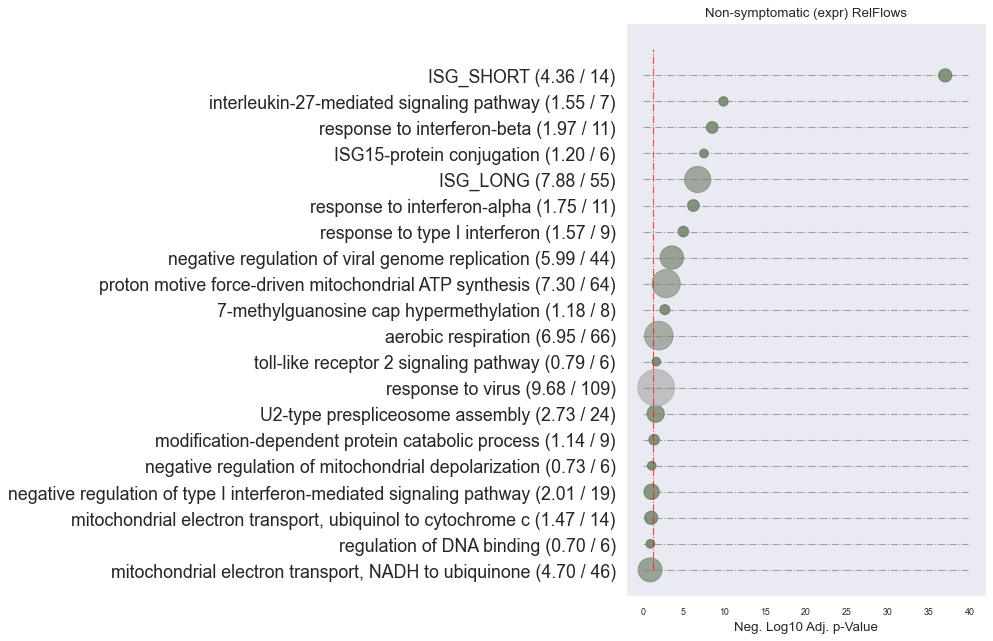

In [24]:
# Select and plot top GO pathways for non-symptomatic group
selPWsGrpGO = pwScoresGrpGO[(pwScoresGrpGO["pw_coverage_adj_pval"] < 1) & (pwScoresGrpGO["pwGenes"] > 5)].sort_values("pw_coverage_adj_pval", ascending=True).head(20)
display(selPWsGrpGO)
fa.plotORAresult(selPWsGrpGO, "Non-symptomatic (expr) RelFlows", numResults=20, figsize=(8,8), outfile="plots/asympt_go")

In [25]:
# Load GO pathways for further analysis
go = fa.get_pathways("go_human.bp.gmt")

Loading pathways from go_human.bp.gmt
Identified 12535 pathways


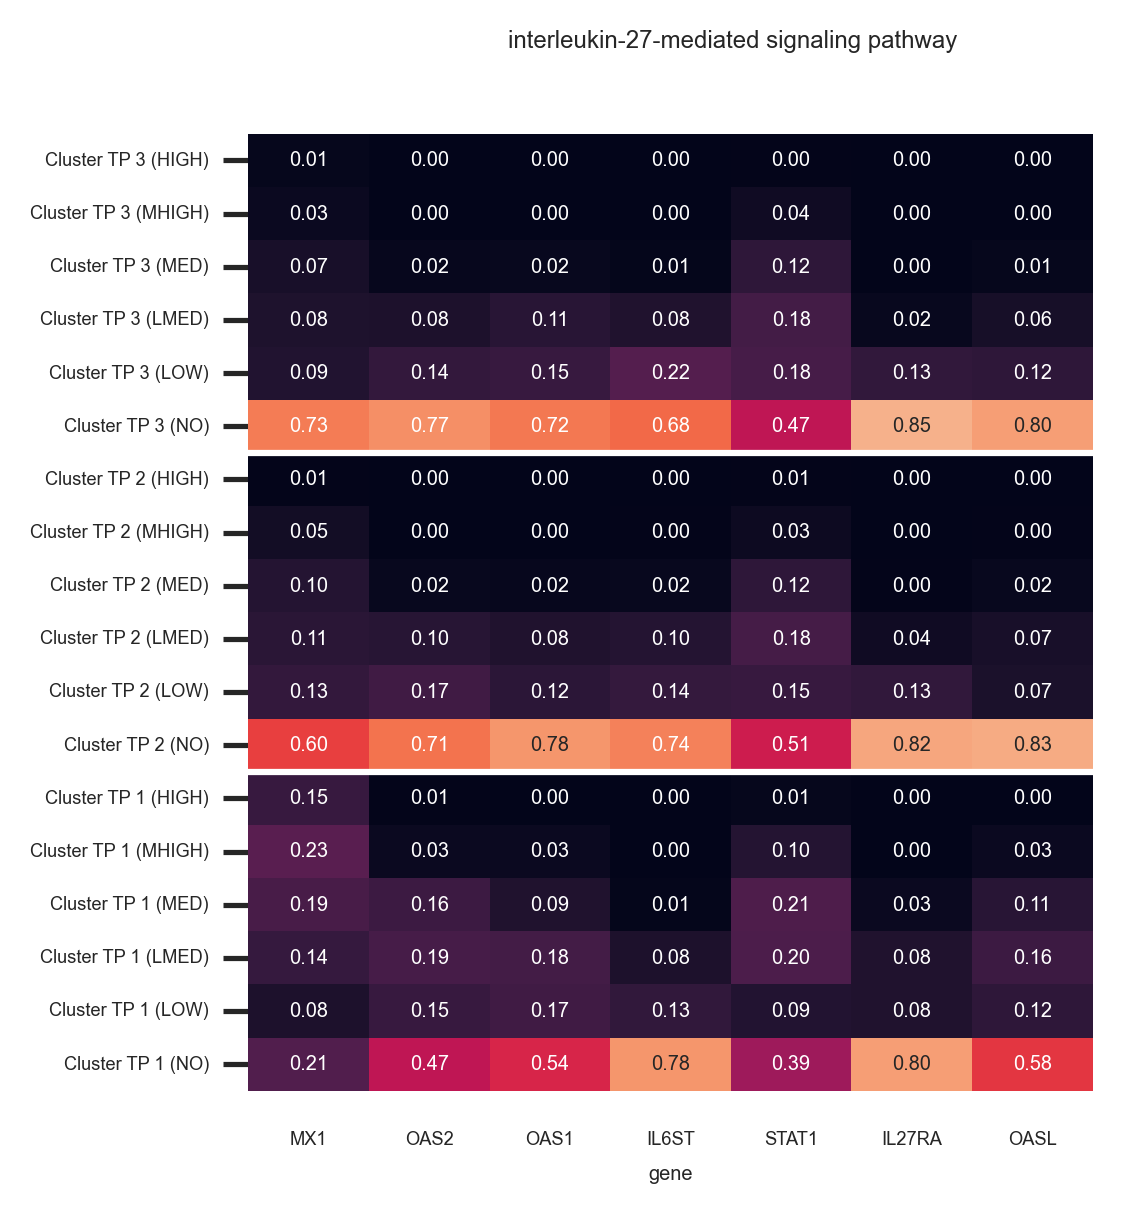

In [26]:
# Plot state memberships for a specific GO pathway
def_memberships = fa.plot_state_memberships(go["GO:0070106"][1], name=go["GO:0070106"][0], figsize=(4,4), outfile="plots/GO_0070106_memberships")

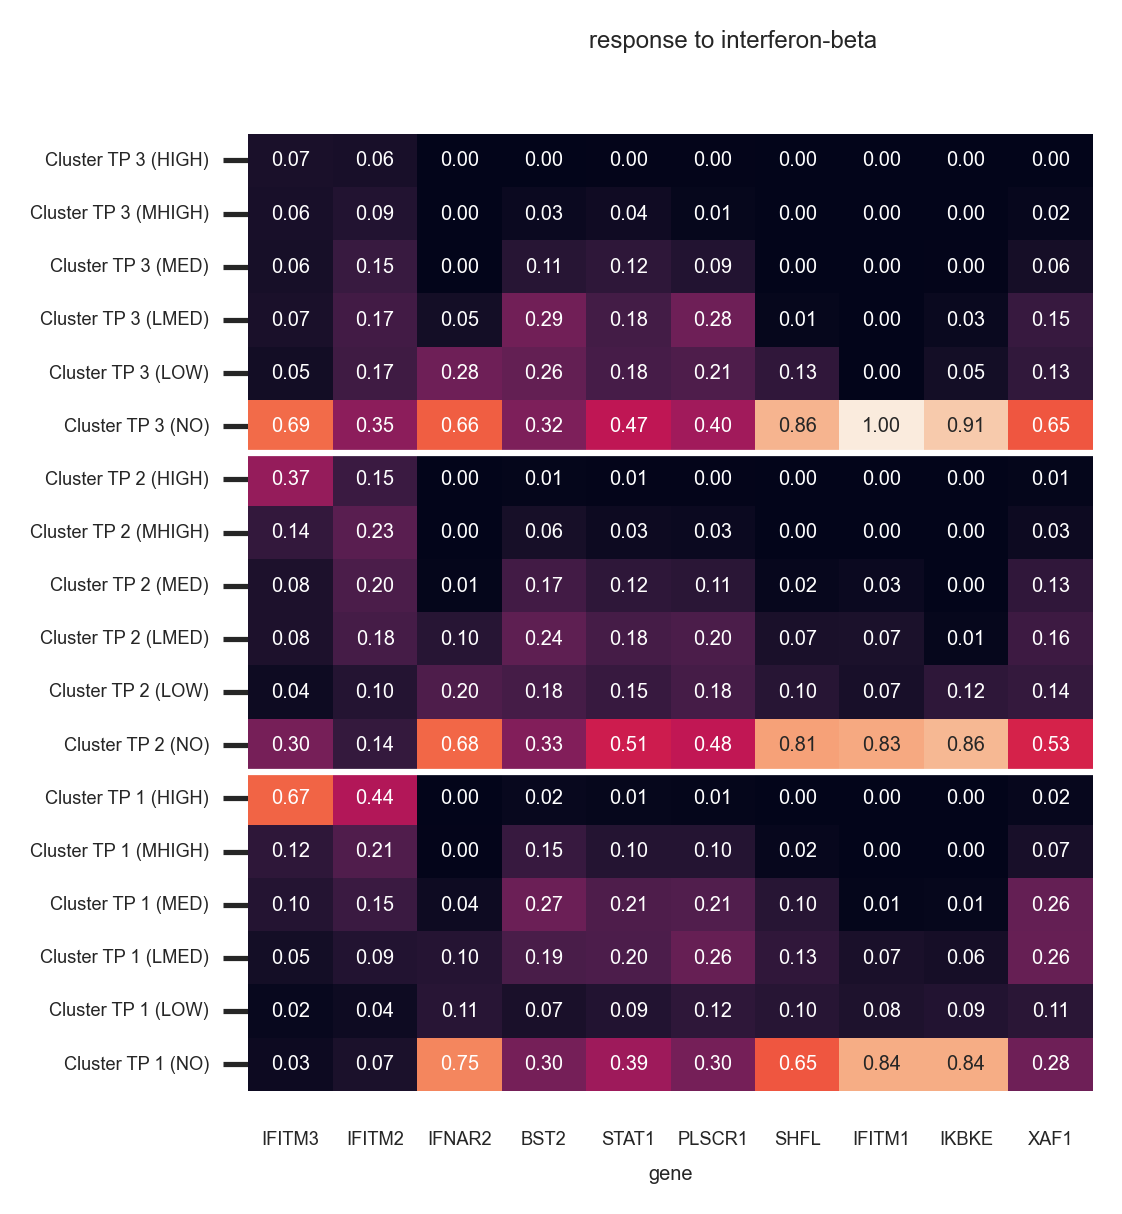

In [27]:
# Plot state memberships for another GO pathway
fa.plot_state_memberships(go["GO:0035456"][1], name=go["GO:0035456"][0], figsize=(4,4), outfile="plots/GO_0035456_memberships")

In [28]:
# ...existing code...